## SFN 24 Results Explorer

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

2024-09-28 14:36:45.854416: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 14:36:47.716997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 14:36:49.672874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [4]:
# overall imports
import importlib
import data

# data load
importlib.reload(data.data_load)
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics, plot_single_model_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [7]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


CPU Usage: 74.9%
RAM Usage: 13.9%
Available RAM: 161.9G
Total RAM: 188.1G
52.4G


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

## Table of Contents
- [Multidataset PLS](#PLS)
    - [AHBA+HCP](#AHBA)
    - [GTEx+HCP](#GTEx)
    - [UTSW+HCP](#UTSW)
- [AHBA+HCP](#AHBA)
    - [Bilinear PLS](#PLS-Sims)
      - [Random Splits](#PLS-Random-Splits)
    - [XGBoost](#XGBoost-Sims)
      - [Random Splits](#XGBoost-Random-Splits)

## Results Analysis

### Random

In [9]:
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs'
os.listdir(SFN_sim_path)

feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']

['transcriptomePCA euclidean functional_pls_community_gridsearch102_4.pickle',
 'transcriptomePCA structural_pls_community_gridsearch102_2.pickle',
 'transcriptome_pls_community_gridsearch101_0.pickle',
 'functional transcriptome_pls_community_gridsearch102_2.pickle',
 'structural euclidean_pls_community_gridsearch102_4.pickle',
 'functional_pls_community_gridsearch102_3.pickle',
 'functional_pls_community_gridsearch102_42.pickle',
 'structural euclidean functional_pls_community_gridsearch102_5.pickle',
 'transcriptome_pls_community_gridsearch101_2.pickle',
 'transcriptomePCA transcriptome_pls_community_gridsearch102_5.pickle',
 'functional_pls_random_gridsearch.pickle',
 'euclidean transcriptome_pls_random_gridsearch.pickle',
 'euclidean transcriptome_pls_community_gridsearch102_5.pickle',
 'structural_xgboost_random_bayessearch.pickle',
 'euclidean functional_pls_community_gridsearch102_4.pickle',
 'transcriptomePCA transcriptome_pls_community_gridsearch102_2.pickle',
 'euclidean tra

In [10]:
def plot_performance(feature_types, model_type='xgboost', cv_split='random', resolution='', search_type='bayes', metric='pearson_corr', 
                     display_train_test=True, sim_path=SFN_sim_path):
    """
    Iterate over each feature type, extract performance results from the pickle files,
    and generate a boxplot for performance metrics.
    
    Args:
    - feature_types: List of feature types.
    - model_type: The type of model to use (e.g., 'xgboost').
    - cv_split: The type of cross-validation split (e.g., 'random').
    - metric: The performance metric to extract (e.g., 'pearson_corr').
    - display_train_test: If True, shows both train and test metrics in the plot.
    - sim_path: Path to the saved pickle files.
    """
    data = []
    
    # Iterate over each feature type and load the corresponding results
    for feature in feature_types:
        print(f'Processing feature: {feature}')
        
        # Construct pickle file name pattern based on feature type, model type, and CV split
        pickle_file_pattern = f"{feature}_{model_type}_{cv_split}_{search_type}search{resolution}.pickle"
        
        # Check if the file exists
        if pickle_file_pattern in os.listdir(sim_path):
            # Extract the performance metrics for the train and test sets
            results = open_pickled_results(pickle_file_pattern, 'SFN_runs/')
            
            if results:
                # Iterate over each fold in the results (assuming fold results are directly stored)
                for fold_idx, fold_results in enumerate(results[0]):
                    #print(fold_idx)
                    #print(fold_results)

                    # Optionally include train metrics
                    if display_train_test:
                        train_score = fold_results['train_metrics'][metric]
                        data.append({'Feature Type': feature, 'Metric': metric, 'Fold': fold_idx, 
                                     'Score': train_score, 'Set': 'Train'})
                    # Extract test metrics
                    test_score = fold_results['test_metrics'][metric]
                    data.append({'Feature Type': feature, 'Metric': metric, 'Fold': fold_idx, 
                                 'Score': test_score, 'Set': 'Test'})
                    
                    
        else:
            print(f"Pickle file not found for feature: {feature}")

    # Convert to DataFrame for easy plotting with seaborn
    import pandas as pd
    results_df = pd.DataFrame(data)
    
    # Plot the results using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Feature Type', y='Score', hue='Set', data=results_df)
    sns.swarmplot(x='Feature Type', y='Score', hue='Set', data=results_df, dodge=True, color=".25", size=5)
    
    plt.title(f'Performance Comparison of {model_type} ({cv_split} CV) on {metric}')
    plt.ylabel(f'{metric.capitalize()} Score')
    plt.ylim(0, 0.8)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


### Random results across models

Processing feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


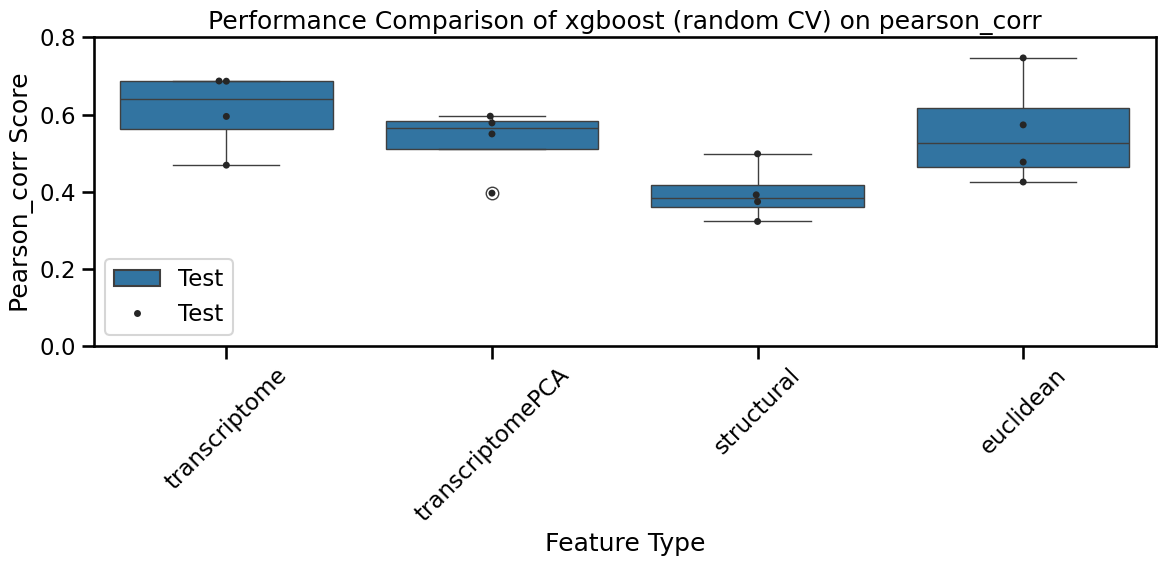

In [11]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', display_train_test=False)

Processing feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


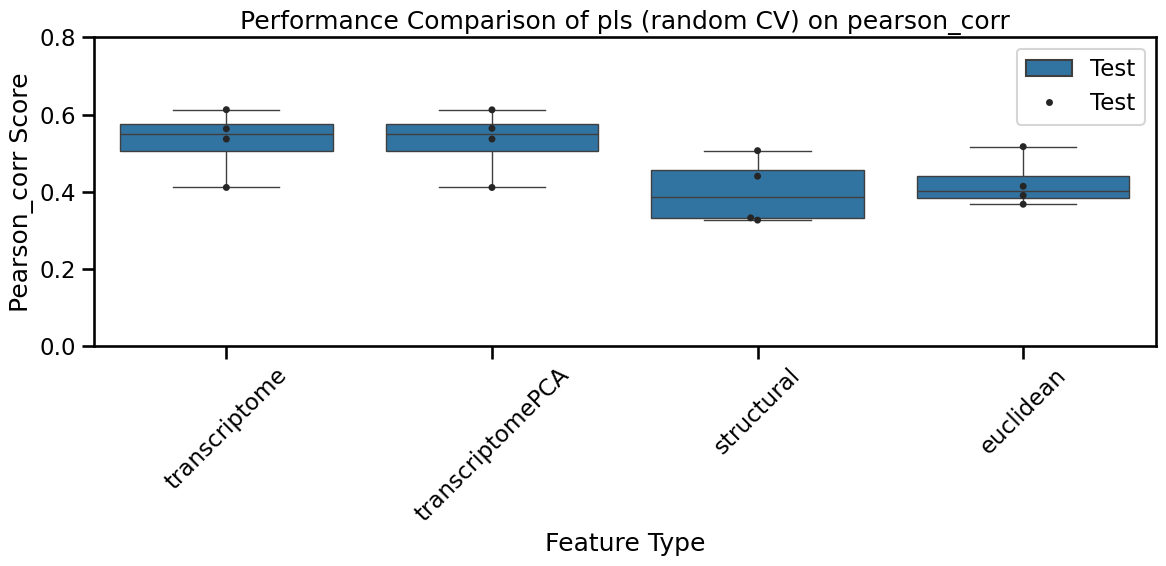

In [12]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='pls', cv_split='random', metric='pearson_corr', search_type='grid', display_train_test=False)

Processing feature: transcriptome
Pickle file not found for feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


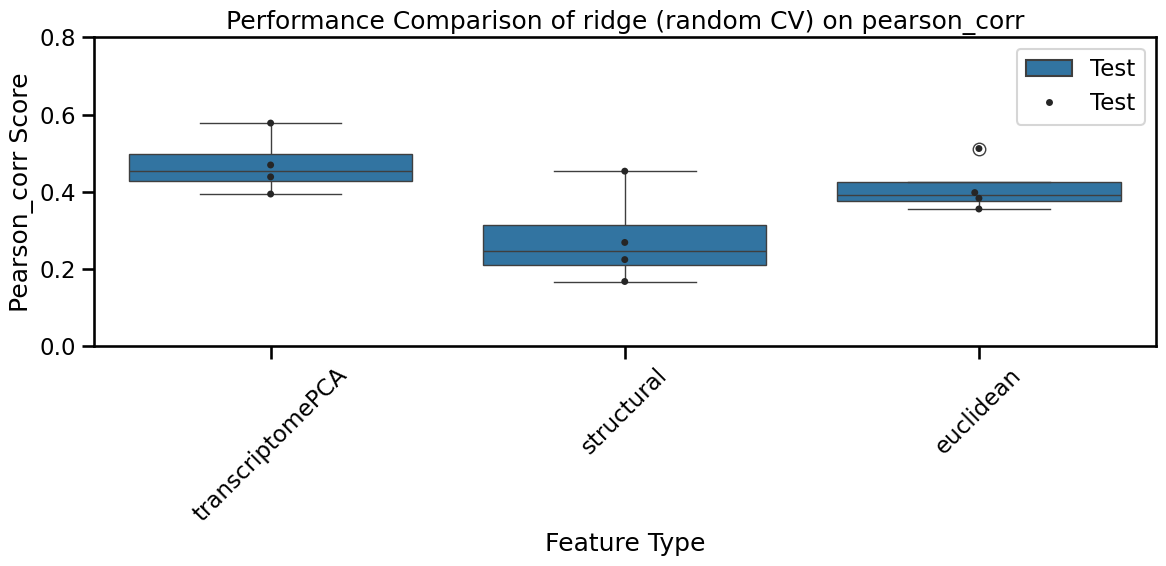

In [13]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='ridge', cv_split='random', metric='pearson_corr', display_train_test=False)

In [50]:
import os
import pickle
import numpy as np
import pandas as pd

def extract_simulation_metrics(sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions=[], seeds=[]):
    """
    Extracts simulation results from pickle files and computes the average Pearson correlation,
    MSE, and standard error over all the folds for the specified parameters.
    
    Args:
    - sim_path: Base directory for the simulations.
    - subfolder: Subfolder within sim_path where simulation results are stored.
    - model_type: The model type used (e.g., 'xgboost', 'pls').
    - cv_type: The cross-validation type (e.g., 'random', 'community').
    - search_method: The search method used (e.g., 'bayessearch', 'gridsearch').
    - feature_types: List of feature types used in simulations (e.g., 'transcriptome', 'euclidean').
    - resolutions: List of resolution values used in simulations. (Can be empty for wildcard)
    - seeds: List of random seed values used in simulations. (Can be empty for wildcard)
    
    Returns:
    - A pandas DataFrame containing the file names and the average Pearson correlation,
      MSE, and standard error for each file.
    """
    
    data = []  # List to store the results
    
    # If resolutions or seeds are empty, set them to a wildcard [''] to ignore the filter
    if not resolutions:
        resolutions = ['']
    if not seeds:
        seeds = ['']
    
    # Iterate over feature types, resolutions, and seeds
    for feature in feature_types:
        for r in resolutions:
            for s in seeds:
                # Construct the expected pickle file name pattern
                resolution_str = str(r).replace('.', '') if r else ''  # If resolution is empty, skip it in the filename
                seed_str = str(s) if s else ''  # If seed is empty, skip it in the filename
                file_pattern = f"{feature}_{model_type}_{cv_type}{resolution_str}_{seed_str}_{search_method}.pickle"
                file_path = os.path.join(sim_path, subfolder, file_pattern)
                
                # Check if the file exists
                if os.path.exists(file_path):
                    # Open the pickle file and load the results
                    with open(file_path, 'rb') as f:
                        results = pickle.load(f)
                    
                    # Extract the metrics for each fold
                    pearson_corrs = []
                    mses = []
                    for fold_result in results[0]:  # Assuming the results are stored in the first element
                        pearson_corrs.append(fold_result['test_metrics']['pearson_corr'])
                        mses.append(fold_result['test_metrics']['mse'])
                    
                    # Compute the mean and standard error
                    mean_pearson_corr = np.mean(pearson_corrs)
                    mean_mse = np.mean(mses)
                    std_err_pearson_corr = np.std(pearson_corrs) / np.sqrt(len(pearson_corrs))
                    std_err_mse = np.std(mses) / np.sqrt(len(mses))
                    
                    # Append the results to the data list
                    data.append({
                        'File Name': file_pattern,
                        'Feature Type': feature,
                        'Mean Pearson Corr': mean_pearson_corr,
                        'Std Err Pearson Corr': std_err_pearson_corr,
                        'Mean MSE': mean_mse,
                        'Std Err MSE': std_err_mse
                    })
                else:
                    print(f"File not found: {file_pattern}")
    
    # Create a DataFrame from the data
    df_results = pd.DataFrame(data)
    
    return df_results

In [52]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results'

# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'random'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # List of seeds

df_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(df_results)

                                            File Name      Feature Type  \
0   transcriptome_xgboost_random_1_bayessearch.pickle     transcriptome   
1   transcriptome_xgboost_random_2_bayessearch.pickle     transcriptome   
2   transcriptome_xgboost_random_3_bayessearch.pickle     transcriptome   
3   transcriptome_xgboost_random_4_bayessearch.pickle     transcriptome   
4   transcriptome_xgboost_random_5_bayessearch.pickle     transcriptome   
5   transcriptome_xgboost_random_6_bayessearch.pickle     transcriptome   
6   transcriptome_xgboost_random_7_bayessearch.pickle     transcriptome   
7   transcriptome_xgboost_random_8_bayessearch.pickle     transcriptome   
8   transcriptome_xgboost_random_9_bayessearch.pickle     transcriptome   
9   transcriptomePCA_xgboost_random_1_bayessearch....  transcriptomePCA   
10  transcriptomePCA_xgboost_random_2_bayessearch....  transcriptomePCA   
11  transcriptomePCA_xgboost_random_3_bayessearch....  transcriptomePCA   
12  transcriptomePCA_xgbo

In [53]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results'

# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01,1.02]  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6]  # List of seeds

df_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(df_results)

File not found: transcriptome_xgboost_community101_6_bayessearch.pickle
File not found: transcriptome_xgboost_community102_6_bayessearch.pickle
File not found: transcriptomePCA_xgboost_community101_6_bayessearch.pickle
File not found: transcriptomePCA_xgboost_community102_6_bayessearch.pickle
File not found: structural_xgboost_community101_6_bayessearch.pickle
File not found: structural_xgboost_community102_6_bayessearch.pickle
File not found: euclidean_xgboost_community101_6_bayessearch.pickle
File not found: euclidean_xgboost_community102_6_bayessearch.pickle
                                            File Name      Feature Type  \
0   transcriptome_xgboost_community101_1_bayessear...     transcriptome   
1   transcriptome_xgboost_community101_2_bayessear...     transcriptome   
2   transcriptome_xgboost_community101_3_bayessear...     transcriptome   
3   transcriptome_xgboost_community101_4_bayessear...     transcriptome   
4   transcriptome_xgboost_community101_5_bayessear...    

In [43]:
import os
import pickle
import pandas as pd
import numpy as np

def load_and_aggregate_results(SFN_sim_path, feature_types, seeds, model_type, cv_type='random', search_method='bayes', metric='pearson_corr'):
    """
    Load pickle files and aggregate the performance results across different seeds and feature types.
    
    Args:
    - SFN_sim_path: Path to the pickle files.
    - feature_types: List of feature types.
    - seeds: List of seed values.
    - model_type: The model type (e.g., 'xgboost' or 'pls').
    - cv_type: Cross-validation type (e.g., 'random', 'community').
    - search_method: Search method used (e.g., 'bayes', 'grid').
    - metric: The metric to extract (e.g., 'pearson_corr').
    
    Returns:
    - performance_df: A DataFrame with aggregated performance data.
    """
    # Initialize list to hold performance data
    performance_data = []
    
    # Iterate over seeds and feature types
    for s in seeds:
        for feature in feature_types:
            # Construct the pickle file name
            pickle_file = f"{feature}_{model_type}_{cv_type}_{s}_{search_method}search.pickle"
            
            # Check if the file exists
            if pickle_file in os.listdir(SFN_sim_path):
                # Load the results from the pickle file
                with open(os.path.join(SFN_sim_path, pickle_file), 'rb') as f:
                    results = pickle.load(f)
                    
                    # Iterate over folds and extract performance metrics (test set performance)
                    for fold_idx, fold_results in enumerate(results[0]):
                        test_score = fold_results['test_metrics'][metric]  # Metric can be changed
                        performance_data.append({
                            'Feature Type': feature,
                            'Seed': s,
                            'Fold': fold_idx,
                            'Score': test_score
                        })

    # Convert the performance data to a DataFrame
    performance_df = pd.DataFrame(performance_data)
    
    # Aggregate by feature type and calculate mean and std deviation
    aggregated_performance = performance_df.groupby('Feature Type').agg(
        Average_Performance=('Score', 'mean'),
        Error=('Score', 'std')
    ).reset_index()

    return aggregated_performance

def plot_aggregated_performance(performance_df, model_type='xgboost'):
    """
    Plot average performance with error bars for each feature type.
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: The type of model to use (e.g., 'xgboost' or 'pls').
    """
    plt.figure(figsize=(10, 6))

    # Plot the average performance with error bars
    sns.barplot(x='Feature Type', y='Average_Performance', data=performance_df, capsize=0.2)

    # Add error bars manually using matplotlib
    plt.errorbar(
        x=np.arange(len(performance_df)),  # x positions
        y=performance_df['Average_Performance'],  # y values
        yerr=performance_df['Error'],  # error values
        fmt='none',  # no connecting line
        capsize=5,   # size of the error bar caps
        color='black',  # color of error bars
        elinewidth=2,  # width of error lines
    )

    plt.title(f'Average Performance of {model_type.upper()} Model (Random Splits)')
    plt.ylabel('Average Pearson Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def display_performance_table(performance_df, model_type='xgboost'):
    """
    Display the performance data in a LaTeX table format.
    
    Args:
    - performance_df: DataFrame containing the performance and error data.
    - model_type: The model type (e.g., 'xgboost', 'pls').
    """
    table_str = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{lcc}\n"
    table_str += "Feature Type & Average Performance & Error \\\\\n\\hline\n"
    
    # Add data from the DataFrame
    for _, row in performance_df.iterrows():
        table_str += f"{row['Feature Type']} & {row['Average_Performance']:.3f} $\\pm$ {row['Error']:.3f} \\\\\n"
    
    table_str += f"\\end{{tabular}}\n\\caption{{Average performance with error for {model_type.upper()} (random splits).}}\n\\end{{table}}"
    
    # Print the table for LaTeX use
    print(table_str)

In [46]:
# For XGBoost
xgboost_performance_df = load_and_aggregate_results(SFN_sim_path, feature_types, seeds, model_type='xgboost', cv_type='random', search_method='bayes')
plot_aggregated_performance(xgboost_performance_df, model_type='xgboost')

# For PLS
#pls_performance_df = load_and_aggregate_results(SFN_sim_path, feature_types, seeds, model_type='pls', cv_type='random', search_method='grid')
#plot_aggregated_performance(pls_performance_df, model_type='pls')


KeyError: 'Average Performance'

<Figure size 1000x600 with 0 Axes>

In [44]:
# Lists to store matching xgboost and pls file names
xgboost_files = []
pls_files = []

# Iterate over resolutions, seeds, and feature types
for r in resolutions:
    for s in seeds:
        for feature in feature_types:
            # Construct the expected file names for xgboost and pls
            xgboost_pickle = f"{feature}_xgboost_{cv_type}_bayessearch{str(r).replace('.', '')}_{s}.pickle"
            pls_pickle = f"{feature}_pls_{cv_type}_gridsearch{str(r).replace('.', '')}_{s}.pickle"
            
            # Check if both xgboost and pls files exist
            xgboost_exists = xgboost_pickle in os.listdir(SFN_sim_path)
            pls_exists = pls_pickle in os.listdir(SFN_sim_path)
            
            # Only include in the lists if both files exist
            if xgboost_exists and pls_exists:
                xgboost_files.append(xgboost_pickle)
                pls_files.append(pls_pickle)

# Print the matching file lists
print("Matching xgboost files:")
for file in xgboost_files:
    print(file)

print("\nMatching pls files:")
for file in pls_files:
    print(file)

Matching xgboost files:

Matching pls files:


In [16]:
import os
import pandas as pd
import numpy as np

def compute_average_performance(model_files, metric='pearson_corr', sim_path='neuroinformatics/GeneEx2Conn/sim/sim_results/SFN_runs/'):
    """
    Compute the average performance and error for each feature type over all folds and splits.
    
    Args:
    - model_files: List of pickle file names for the given model (either xgboost or pls).
    - metric: The performance metric to extract (e.g., 'pearson_corr').
    - sim_path: Path to the saved pickle files.
    
    Returns:
    - A DataFrame with feature types, average performance, and error.
    """
    performance_data = []

    # Iterate over all model files
    for file in model_files:
        # Load the results from the pickle file
        feature = file.split('_')[0]  # Extract feature type from filename
        results = open_pickled_results(file, 'SFN_runs/')
        
        # If results exist, extract the fold metrics
        if results:
            fold_metrics = []
            for fold_idx, fold_results in enumerate(results[0]):
                test_score = fold_results['test_metrics'][metric]
                fold_metrics.append(test_score)
            
            # Compute mean and standard error for this feature across folds
            avg_performance = np.mean(fold_metrics)
            std_error = np.std(fold_metrics) / np.sqrt(len(fold_metrics))
            
            # Store results
            performance_data.append({
                'Feature Type': feature,
                'Average Performance': avg_performance,
                'Error': std_error
            })

    # Convert to a DataFrame
    performance_df = pd.DataFrame(performance_data)
    return performance_df

In [17]:
# Assuming 'xgboost_files' and 'pls_files' are the lists you generated previously

# Compute performance for xgboost
xgboost_performance_df = compute_average_performance(xgboost_files, metric='mse')

# Compute performance for pls
pls_performance_df = compute_average_performance(pls_files, metric='mse')

# Display the results
print("XGBoost Performance:")
print(xgboost_performance_df)

print("\nPLS Performance:")
print(pls_performance_df)

XGBoost Performance:
        Feature Type  Average Performance     Error
0   transcriptomePCA             0.093832  0.034235
1         structural             0.077549  0.032354
2          euclidean             0.083332  0.024492
3         functional             0.034971  0.014135
4      transcriptome             0.089281  0.028346
5   transcriptomePCA             0.054919  0.007676
6         structural             0.059082  0.010384
7          euclidean             0.068329  0.009729
8         functional             0.021123  0.004404
9      transcriptome             0.068781  0.005352
10     transcriptome             0.088855  0.028469
11  transcriptomePCA             0.058752  0.012292
12        structural             0.062021  0.015438
13         euclidean             0.045489  0.004568
14        functional             0.022267  0.007344
15     transcriptome             0.047982  0.008736
16  transcriptomePCA             0.093832  0.034235
17        structural             0.077549  

Performance Table for XGBOOST Model (Community Split)

Performance Table for PLS Model (Community Split)



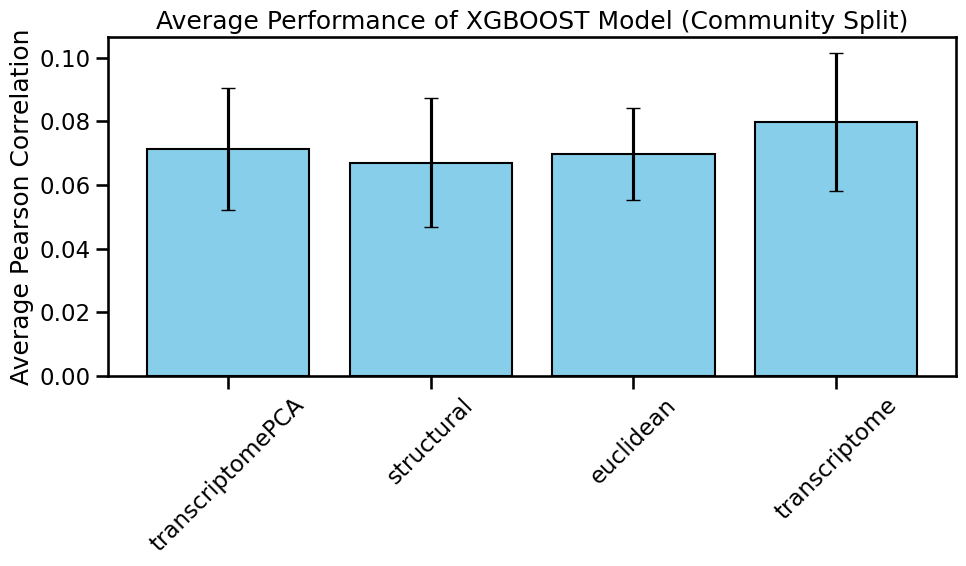

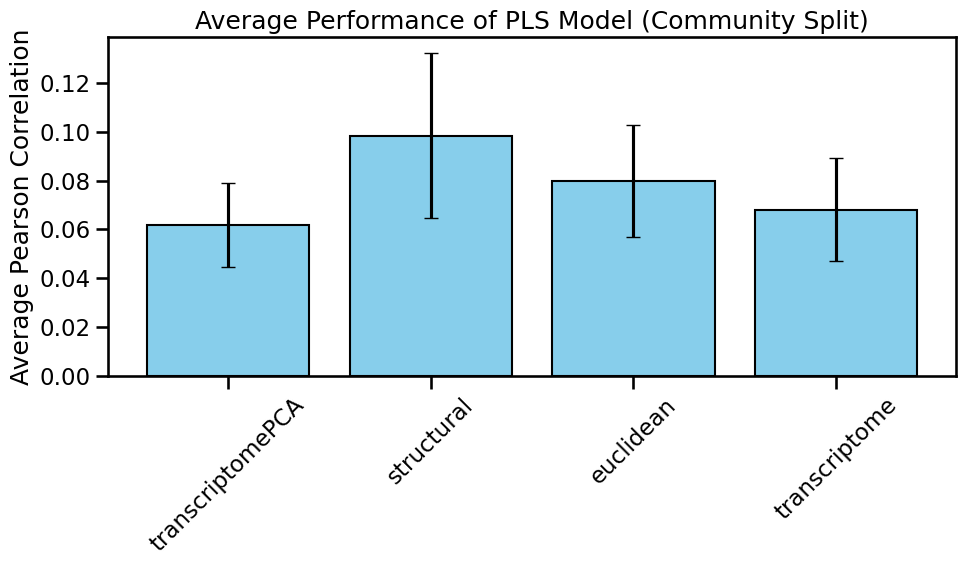

In [35]:
def aggregate_performance_over_splits(file_list, metric='pearson_corr'):
    """
    Aggregate the performance across all splits for each feature type.
    
    Args:
    - file_list: List of file paths for the simulations to process.
    - metric: The performance metric to extract (default: 'pearson_corr').
    
    Returns:
    - A DataFrame with aggregated average performance and error (standard deviation) per feature type.
    """
    aggregated_data = {}

    for file in file_list:
        # Extract the feature type from the file name
        feature_type = file.split('_')[0]
        
        # Load the pickle file results
        results = open_pickled_results(file, 'SFN_runs/')
        
        # Collect all test scores across all folds
        test_scores = []
        
        for fold_results in results[0]:  # Assuming first element contains folds
            test_score = fold_results['test_metrics'][metric]
            test_scores.append(test_score)
        
        # Calculate mean and standard deviation for the metric
        mean_score = np.mean(test_scores)
        std_error = np.std(test_scores) / np.sqrt(len(test_scores))  # Standard error of the mean
        
        # Store the aggregated data
        if feature_type not in aggregated_data:
            aggregated_data[feature_type] = {'Average Performance': [], 'Error': []}
        
        aggregated_data[feature_type]['Average Performance'].append(mean_score)
        aggregated_data[feature_type]['Error'].append(std_error)
    
    # Convert the aggregated data to a DataFrame
    feature_types = list(aggregated_data.keys())
    avg_performance = [np.mean(aggregated_data[ft]['Average Performance']) for ft in feature_types]
    avg_error = [np.mean(aggregated_data[ft]['Error']) for ft in feature_types]
    
    return pd.DataFrame({'Feature Type': feature_types, 'Average Performance': avg_performance, 'Error': avg_error})


def plot_aggregated_performance(performance_df, model_type='xgboost', selected_features=None):
    """
    Plot the average performance with error bars for selected feature types.
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: Model type (either 'xgboost' or 'pls') for plot title.
    - selected_features: List of feature types to display (optional). If None, all features will be displayed.
    """
    # Filter the DataFrame to include only the selected features if provided
    if selected_features is not None:
        performance_df = performance_df[performance_df['Feature Type'].isin(selected_features)]
    
    plt.figure(figsize=(10, 6))
    
    # Plot the average performance with error bars
    plt.bar(performance_df['Feature Type'], performance_df['Average Performance'], 
            yerr=performance_df['Error'], capsize=5, color='skyblue', edgecolor='black')
    
    plt.title(f'Average Performance of {model_type.upper()} Model (Community Split)')
    plt.ylabel('Average Pearson Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_performance_table(performance_df, model_type='xgboost', selected_features=None):
    """
    Create a table format showing the average performance with +/- error for selected feature types.
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: Model type (either 'xgboost' or 'pls') for plot title.
    - selected_features: List of feature types to display (optional). If None, all features will be displayed.
    
    Returns:
    - A formatted DataFrame showing "mean ± error" for each feature.
    """
    # Filter the DataFrame to include only the selected features if provided
    if selected_features is not None:
        performance_df = performance_df[performance_df['Feature Type'].isin(selected_features)]
    
    # Create a new column with formatted "mean ± error"
    performance_df['Performance ± Error'] = performance_df.apply(
        lambda row: f"{row['Average Performance']:.2f} ± {row['Error']:.2f}", axis=1
    )
    
    # Select only the relevant columns for display
    table_df = performance_df[['Feature Type', 'Performance ± Error']]
    
    # Add title to the table
    print(f"Performance Table for {model_type.upper()} Model (Community Split)\n")
    
    return table_df



# Example usage:
# First, aggregate the data
xgboost_performance_df = aggregate_performance_over_splits(xgboost_files, metric='mse')
pls_performance_df = aggregate_performance_over_splits(pls_files, metric='mse')

# Example usage:
# Generate performance tables for xgboost and pls
xgboost_table = create_performance_table(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
pls_table = create_performance_table(pls_performance_df, model_type='pls', selected_features=selected_features)

# Display the tables
xgboost_table
pls_table

# Then, plot the results
# Example: Only display 'transcriptome' and 'structural'
selected_features = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

plot_aggregated_performance(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
plot_aggregated_performance(pls_performance_df, model_type='pls', selected_features=selected_features)

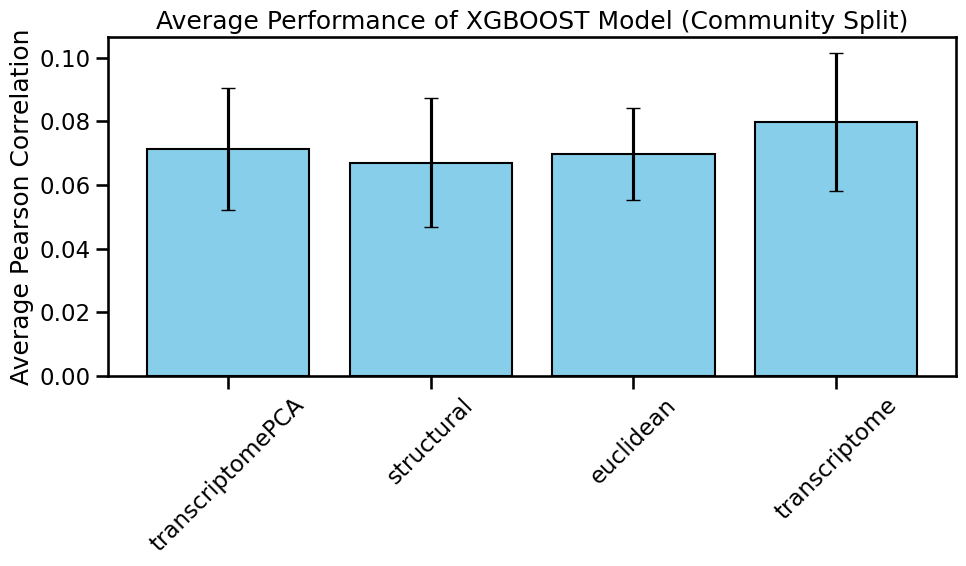

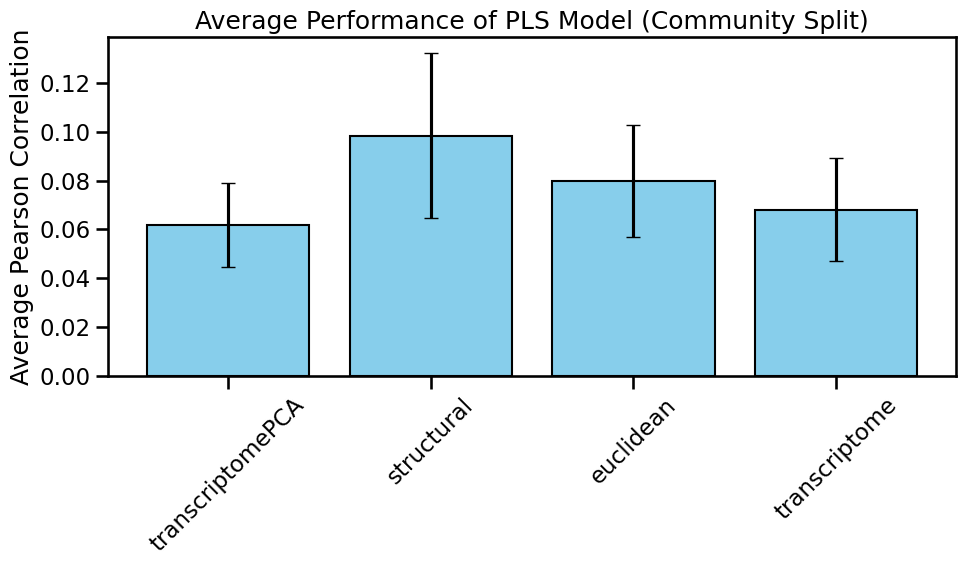

In [33]:

# Then, plot the results
# Example: Only display 'transcriptome' and 'structural'
selected_features = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

plot_aggregated_performance(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
plot_aggregated_performance(pls_performance_df, model_type='pls', selected_features=selected_features)

### Community results across models

In [14]:
import os

# Define the parameters for resolutions, seeds, and feature types
feature_types = ['transcriptomePCA', 'structural', 'euclidean', 'functional', 'transcriptome']
resolutions = [1.01, 1.02]
seeds = [1, 2, 3, 4, 5, 42]
models = ['xgboost', 'pls']
search_methods = {'xgboost': 'bayes', 'pls': 'grid'}
cv_type = 'community'

# Iterate over resolutions, seeds, and feature types for both models
for model_type in models:
    search_method = search_methods[model_type]
    for r in resolutions:
        for s in seeds:
            for feature in feature_types:
                # Construct the expected pickle file name
                pickle_file = f"{feature}_{model_type}_{cv_type}_{search_method}search{str(r).replace('.', '')}_{s}.pickle"
                
                # Check if the file exists in the sim_path
                if pickle_file in os.listdir(SFN_sim_path):
                    print(f"File exists: {pickle_file}")
                else:
                    print(f"File NOT found: {pickle_file}")

File NOT found: transcriptomePCA_xgboost_community_bayessearch101_1.pickle
File NOT found: structural_xgboost_community_bayessearch101_1.pickle
File NOT found: euclidean_xgboost_community_bayessearch101_1.pickle
File NOT found: functional_xgboost_community_bayessearch101_1.pickle
File NOT found: transcriptome_xgboost_community_bayessearch101_1.pickle
File exists: transcriptomePCA_xgboost_community_bayessearch101_2.pickle
File exists: structural_xgboost_community_bayessearch101_2.pickle
File exists: euclidean_xgboost_community_bayessearch101_2.pickle
File exists: functional_xgboost_community_bayessearch101_2.pickle
File exists: transcriptome_xgboost_community_bayessearch101_2.pickle
File exists: transcriptomePCA_xgboost_community_bayessearch101_3.pickle
File exists: structural_xgboost_community_bayessearch101_3.pickle
File exists: euclidean_xgboost_community_bayessearch101_3.pickle
File exists: functional_xgboost_community_bayessearch101_3.pickle
File exists: transcriptome_xgboost_commu

In [15]:
# Lists to store matching xgboost and pls file names
xgboost_files = []
pls_files = []

# Iterate over resolutions, seeds, and feature types
for r in resolutions:
    for s in seeds:
        for feature in feature_types:
            # Construct the expected file names for xgboost and pls
            xgboost_pickle = f"{feature}_xgboost_{cv_type}_bayessearch{str(r).replace('.', '')}_{s}.pickle"
            pls_pickle = f"{feature}_pls_{cv_type}_gridsearch{str(r).replace('.', '')}_{s}.pickle"
            
            # Check if both xgboost and pls files exist
            xgboost_exists = xgboost_pickle in os.listdir(SFN_sim_path)
            pls_exists = pls_pickle in os.listdir(SFN_sim_path)
            
            # Only include in the lists if both files exist
            if xgboost_exists and pls_exists:
                xgboost_files.append(xgboost_pickle)
                pls_files.append(pls_pickle)

# Print the matching file lists
print("Matching xgboost files:")
for file in xgboost_files:
    print(file)

print("\nMatching pls files:")
for file in pls_files:
    print(file)

Matching xgboost files:
transcriptomePCA_xgboost_community_bayessearch101_2.pickle
structural_xgboost_community_bayessearch101_2.pickle
euclidean_xgboost_community_bayessearch101_2.pickle
functional_xgboost_community_bayessearch101_2.pickle
transcriptome_xgboost_community_bayessearch101_2.pickle
transcriptomePCA_xgboost_community_bayessearch101_3.pickle
structural_xgboost_community_bayessearch101_3.pickle
euclidean_xgboost_community_bayessearch101_3.pickle
functional_xgboost_community_bayessearch101_3.pickle
transcriptome_xgboost_community_bayessearch101_3.pickle
transcriptome_xgboost_community_bayessearch101_4.pickle
transcriptomePCA_xgboost_community_bayessearch101_42.pickle
structural_xgboost_community_bayessearch101_42.pickle
euclidean_xgboost_community_bayessearch101_42.pickle
functional_xgboost_community_bayessearch101_42.pickle
transcriptome_xgboost_community_bayessearch101_42.pickle
transcriptomePCA_xgboost_community_bayessearch102_2.pickle
structural_xgboost_community_bayessea

In [16]:
import os
import pandas as pd
import numpy as np

def compute_average_performance(model_files, metric='pearson_corr', sim_path='neuroinformatics/GeneEx2Conn/sim/sim_results/SFN_runs/'):
    """
    Compute the average performance and error for each feature type over all folds and splits.
    
    Args:
    - model_files: List of pickle file names for the given model (either xgboost or pls).
    - metric: The performance metric to extract (e.g., 'pearson_corr').
    - sim_path: Path to the saved pickle files.
    
    Returns:
    - A DataFrame with feature types, average performance, and error.
    """
    performance_data = []

    # Iterate over all model files
    for file in model_files:
        # Load the results from the pickle file
        feature = file.split('_')[0]  # Extract feature type from filename
        results = open_pickled_results(file, 'SFN_runs/')
        
        # If results exist, extract the fold metrics
        if results:
            fold_metrics = []
            for fold_idx, fold_results in enumerate(results[0]):
                test_score = fold_results['test_metrics'][metric]
                fold_metrics.append(test_score)
            
            # Compute mean and standard error for this feature across folds
            avg_performance = np.mean(fold_metrics)
            std_error = np.std(fold_metrics) / np.sqrt(len(fold_metrics))
            
            # Store results
            performance_data.append({
                'Feature Type': feature,
                'Average Performance': avg_performance,
                'Error': std_error
            })

    # Convert to a DataFrame
    performance_df = pd.DataFrame(performance_data)
    return performance_df

In [17]:
# Assuming 'xgboost_files' and 'pls_files' are the lists you generated previously

# Compute performance for xgboost
xgboost_performance_df = compute_average_performance(xgboost_files, metric='mse')

# Compute performance for pls
pls_performance_df = compute_average_performance(pls_files, metric='mse')

# Display the results
print("XGBoost Performance:")
print(xgboost_performance_df)

print("\nPLS Performance:")
print(pls_performance_df)

XGBoost Performance:
        Feature Type  Average Performance     Error
0   transcriptomePCA             0.093832  0.034235
1         structural             0.077549  0.032354
2          euclidean             0.083332  0.024492
3         functional             0.034971  0.014135
4      transcriptome             0.089281  0.028346
5   transcriptomePCA             0.054919  0.007676
6         structural             0.059082  0.010384
7          euclidean             0.068329  0.009729
8         functional             0.021123  0.004404
9      transcriptome             0.068781  0.005352
10     transcriptome             0.088855  0.028469
11  transcriptomePCA             0.058752  0.012292
12        structural             0.062021  0.015438
13         euclidean             0.045489  0.004568
14        functional             0.022267  0.007344
15     transcriptome             0.047982  0.008736
16  transcriptomePCA             0.093832  0.034235
17        structural             0.077549  

Performance Table for XGBOOST Model (Community Split)

Performance Table for PLS Model (Community Split)



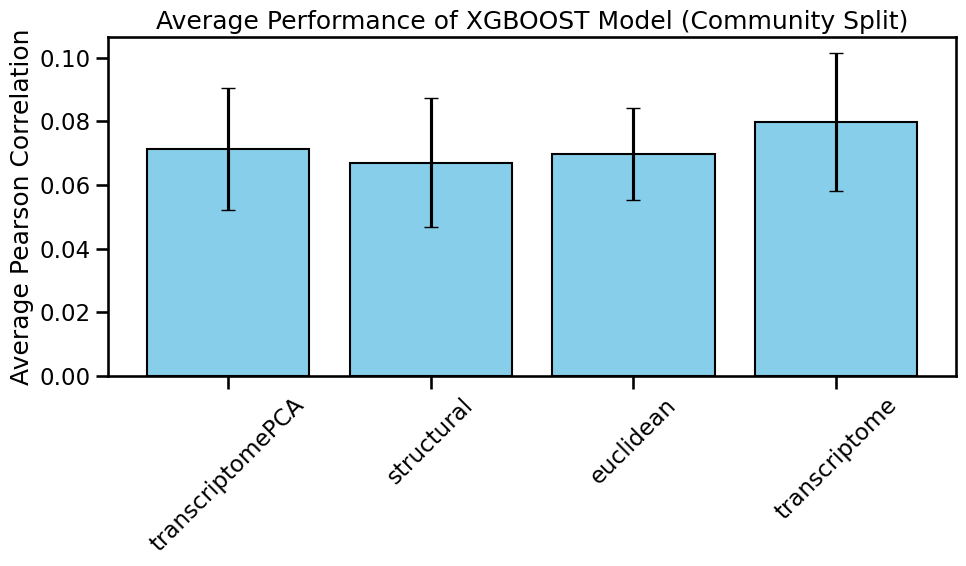

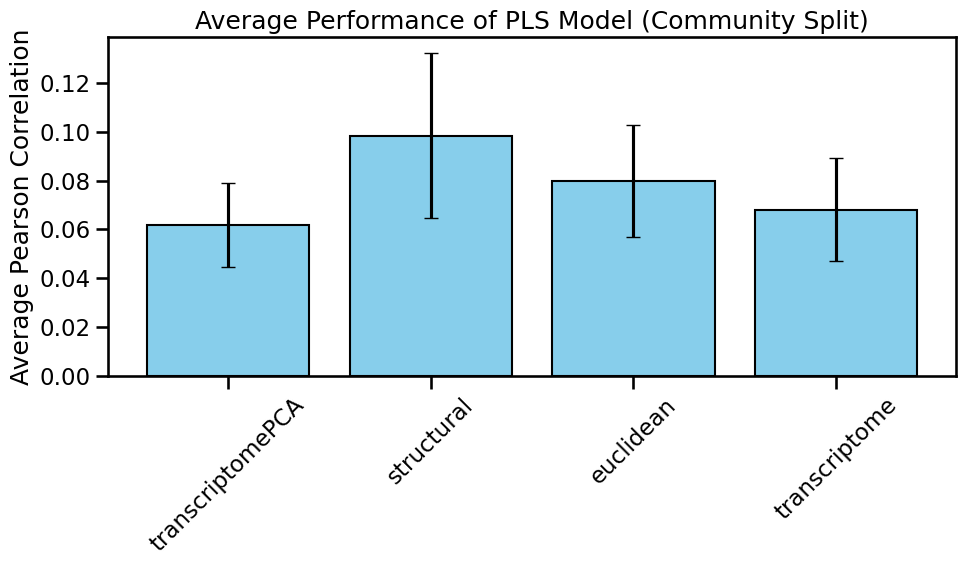

In [35]:
def aggregate_performance_over_splits(file_list, metric='pearson_corr'):
    """
    Aggregate the performance across all splits for each feature type.
    
    Args:
    - file_list: List of file paths for the simulations to process.
    - metric: The performance metric to extract (default: 'pearson_corr').
    
    Returns:
    - A DataFrame with aggregated average performance and error (standard deviation) per feature type.
    """
    aggregated_data = {}

    for file in file_list:
        # Extract the feature type from the file name
        feature_type = file.split('_')[0]
        
        # Load the pickle file results
        results = open_pickled_results(file, 'SFN_runs/')
        
        # Collect all test scores across all folds
        test_scores = []
        
        for fold_results in results[0]:  # Assuming first element contains folds
            test_score = fold_results['test_metrics'][metric]
            test_scores.append(test_score)
        
        # Calculate mean and standard deviation for the metric
        mean_score = np.mean(test_scores)
        std_error = np.std(test_scores) / np.sqrt(len(test_scores))  # Standard error of the mean
        
        # Store the aggregated data
        if feature_type not in aggregated_data:
            aggregated_data[feature_type] = {'Average Performance': [], 'Error': []}
        
        aggregated_data[feature_type]['Average Performance'].append(mean_score)
        aggregated_data[feature_type]['Error'].append(std_error)
    
    # Convert the aggregated data to a DataFrame
    feature_types = list(aggregated_data.keys())
    avg_performance = [np.mean(aggregated_data[ft]['Average Performance']) for ft in feature_types]
    avg_error = [np.mean(aggregated_data[ft]['Error']) for ft in feature_types]
    
    return pd.DataFrame({'Feature Type': feature_types, 'Average Performance': avg_performance, 'Error': avg_error})


def plot_aggregated_performance(performance_df, model_type='xgboost', selected_features=None):
    """
    Plot the average performance with error bars for selected feature types.
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: Model type (either 'xgboost' or 'pls') for plot title.
    - selected_features: List of feature types to display (optional). If None, all features will be displayed.
    """
    # Filter the DataFrame to include only the selected features if provided
    if selected_features is not None:
        performance_df = performance_df[performance_df['Feature Type'].isin(selected_features)]
    
    plt.figure(figsize=(10, 6))
    
    # Plot the average performance with error bars
    plt.bar(performance_df['Feature Type'], performance_df['Average Performance'], 
            yerr=performance_df['Error'], capsize=5, color='skyblue', edgecolor='black')
    
    plt.title(f'Average Performance of {model_type.upper()} Model (Community Split)')
    plt.ylabel('Average Pearson Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_performance_table(performance_df, model_type='xgboost', selected_features=None):
    """
    Create a table format showing the average performance with +/- error for selected feature types.
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: Model type (either 'xgboost' or 'pls') for plot title.
    - selected_features: List of feature types to display (optional). If None, all features will be displayed.
    
    Returns:
    - A formatted DataFrame showing "mean ± error" for each feature.
    """
    # Filter the DataFrame to include only the selected features if provided
    if selected_features is not None:
        performance_df = performance_df[performance_df['Feature Type'].isin(selected_features)]
    
    # Create a new column with formatted "mean ± error"
    performance_df['Performance ± Error'] = performance_df.apply(
        lambda row: f"{row['Average Performance']:.2f} ± {row['Error']:.2f}", axis=1
    )
    
    # Select only the relevant columns for display
    table_df = performance_df[['Feature Type', 'Performance ± Error']]
    
    # Add title to the table
    print(f"Performance Table for {model_type.upper()} Model (Community Split)\n")
    
    return table_df



# Example usage:
# First, aggregate the data
xgboost_performance_df = aggregate_performance_over_splits(xgboost_files, metric='mse')
pls_performance_df = aggregate_performance_over_splits(pls_files, metric='mse')

# Example usage:
# Generate performance tables for xgboost and pls
xgboost_table = create_performance_table(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
pls_table = create_performance_table(pls_performance_df, model_type='pls', selected_features=selected_features)

# Display the tables
xgboost_table
pls_table

# Then, plot the results
# Example: Only display 'transcriptome' and 'structural'
selected_features = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

plot_aggregated_performance(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
plot_aggregated_performance(pls_performance_df, model_type='pls', selected_features=selected_features)

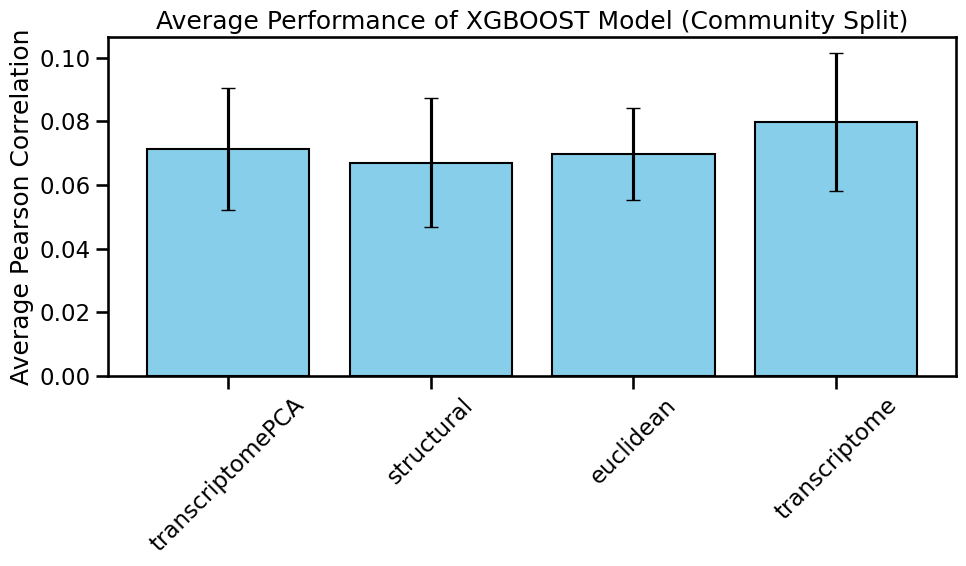

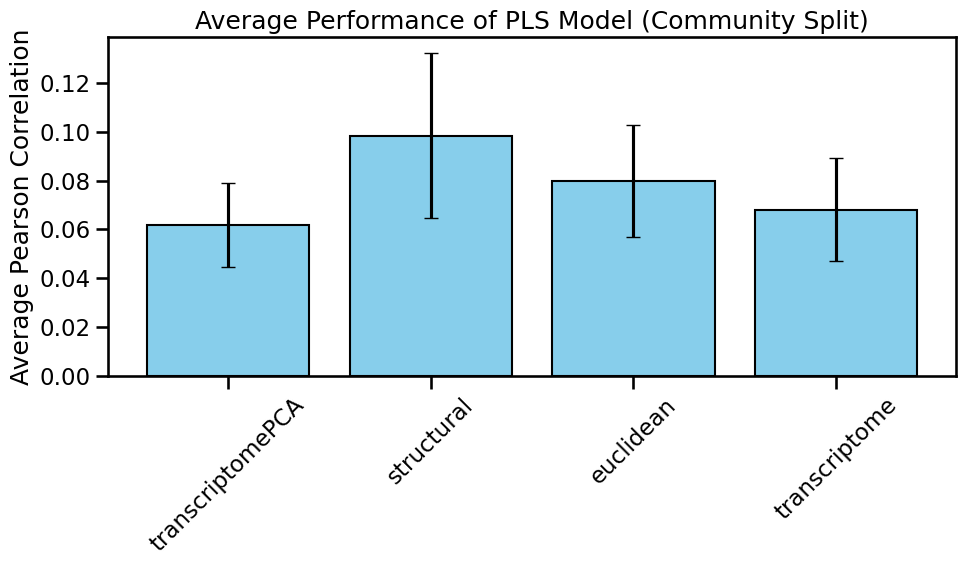

In [33]:

# Then, plot the results
# Example: Only display 'transcriptome' and 'structural'
selected_features = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

plot_aggregated_performance(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
plot_aggregated_performance(pls_performance_df, model_type='pls', selected_features=selected_features)

In [20]:
# Generate performance tables for xgboost and pls
xgboost_table = create_performance_table(xgboost_performance_df, model_type='xgboost', selected_features=selected_features)
pls_table = create_performance_table(pls_performance_df, model_type='pls', selected_features=selected_features)

# Display the tables
xgboost_table

Performance Table for XGBOOST Model (Community Split)

Performance Table for PLS Model (Community Split)



,Feature Type,Performance ± Error
0,transcriptomePCA,0.07 ± 0.02
1,structural,0.07 ± 0.02
2,euclidean,0.07 ± 0.01
4,transcriptome,0.08 ± 0.02


In [21]:
pls_table

,Feature Type,Performance ± Error
0,transcriptomePCA,0.06 ± 0.02
1,structural,0.10 ± 0.03
2,euclidean,0.08 ± 0.02
4,transcriptome,0.07 ± 0.02


transcriptome


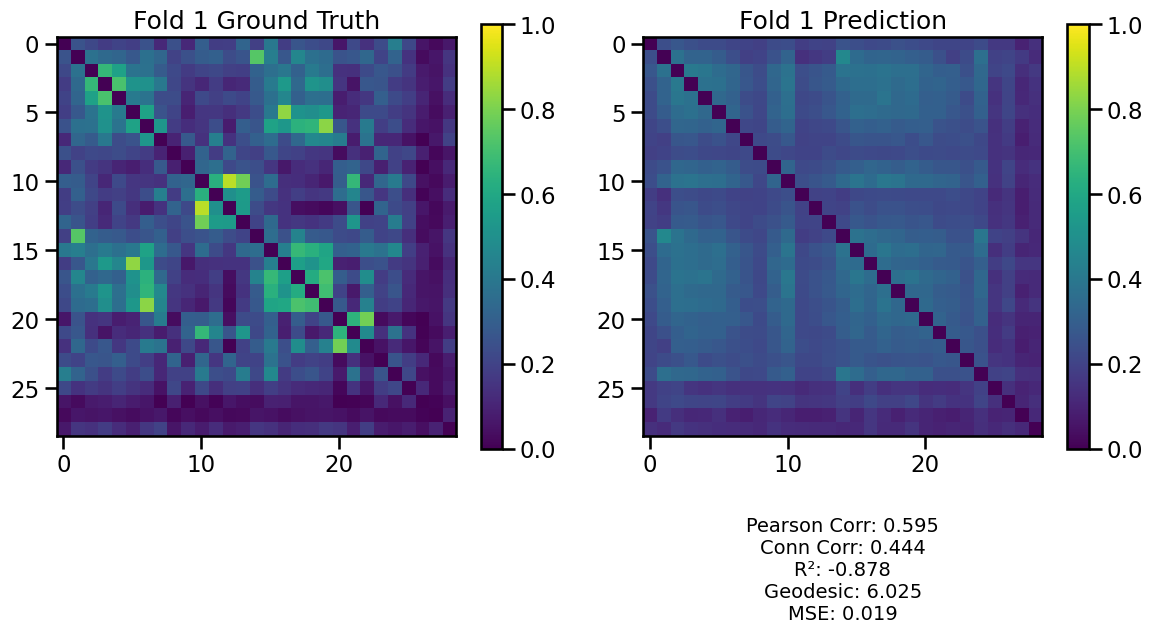

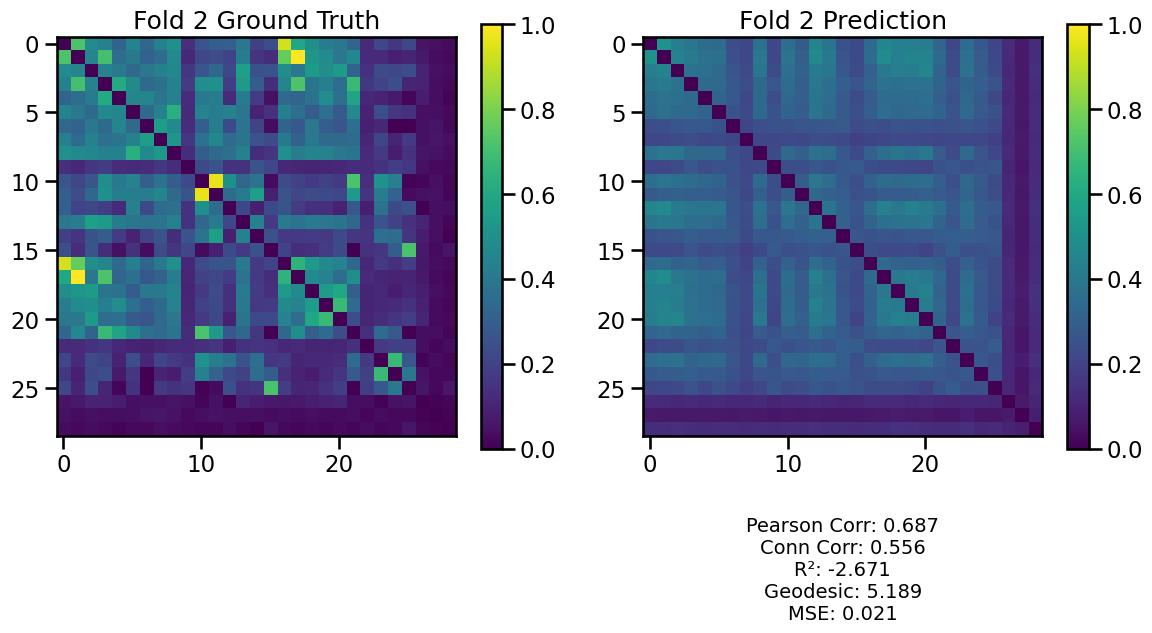

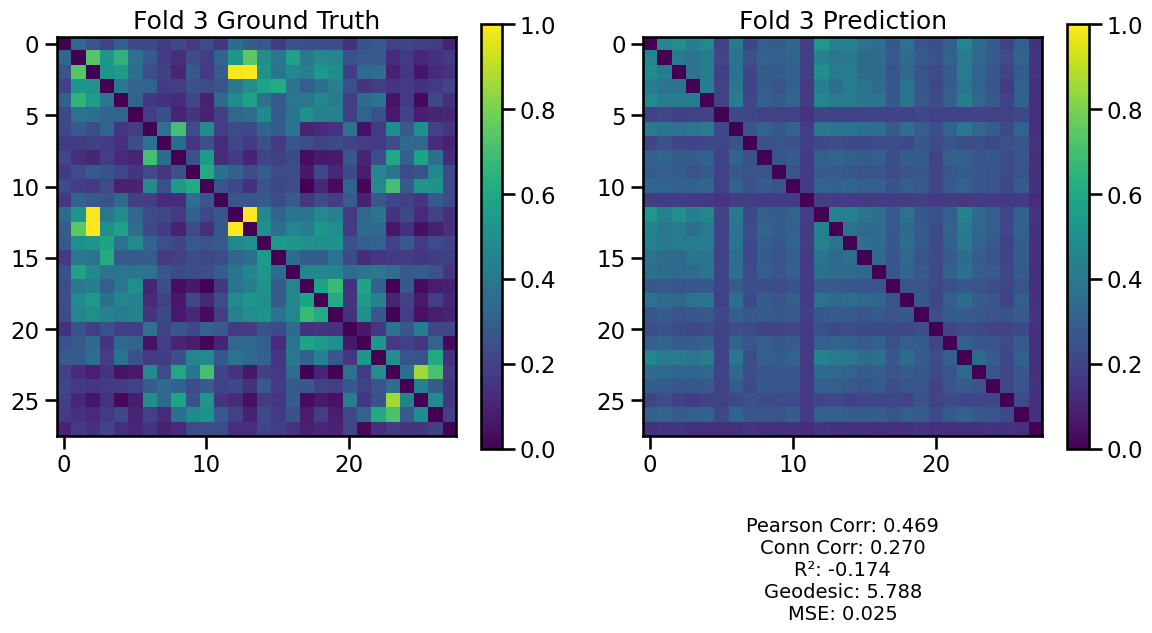

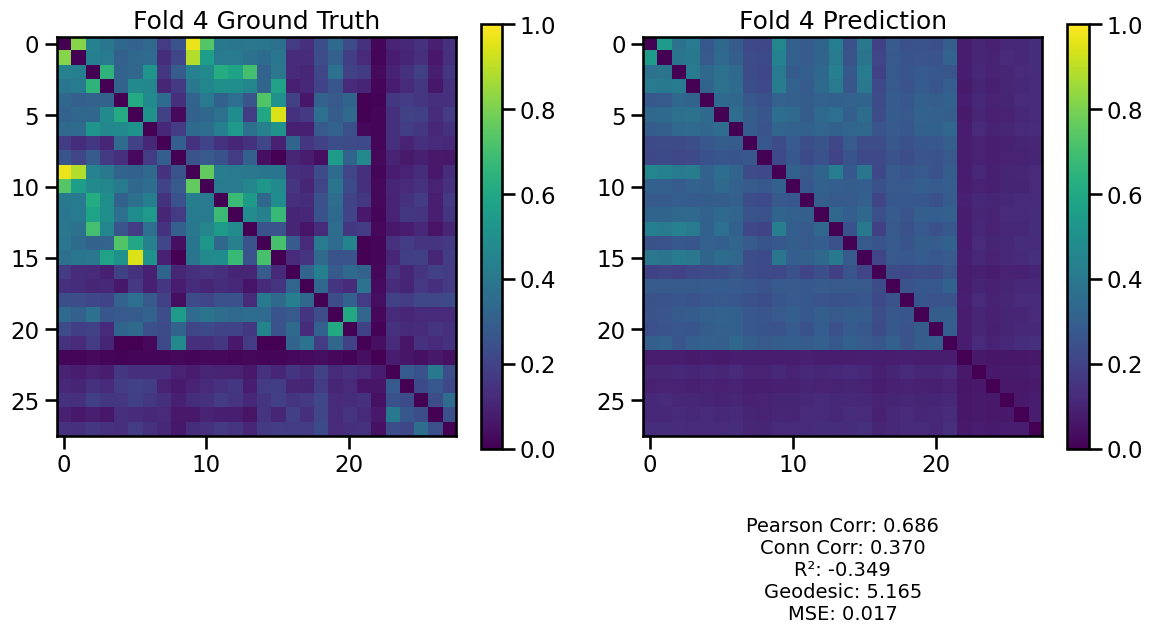

transcriptomePCA


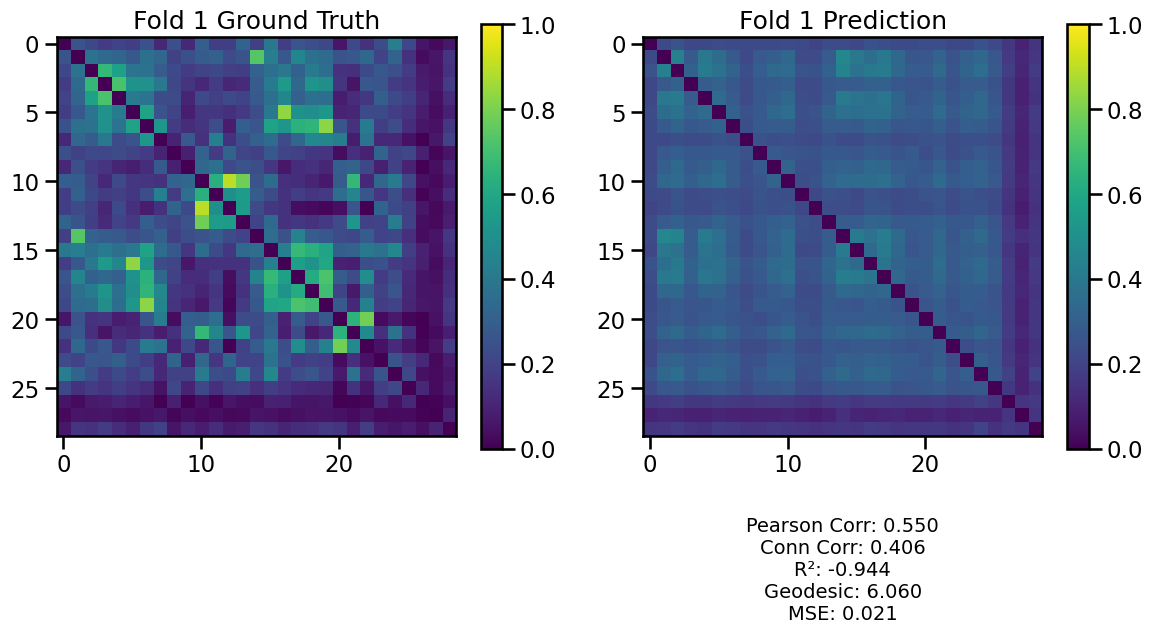

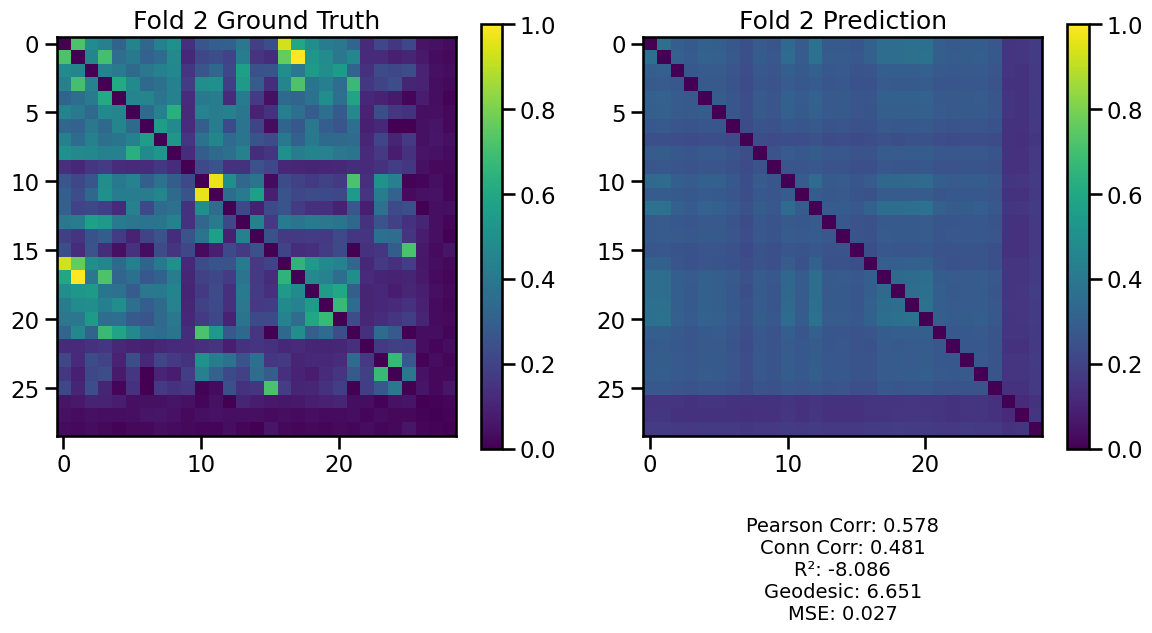

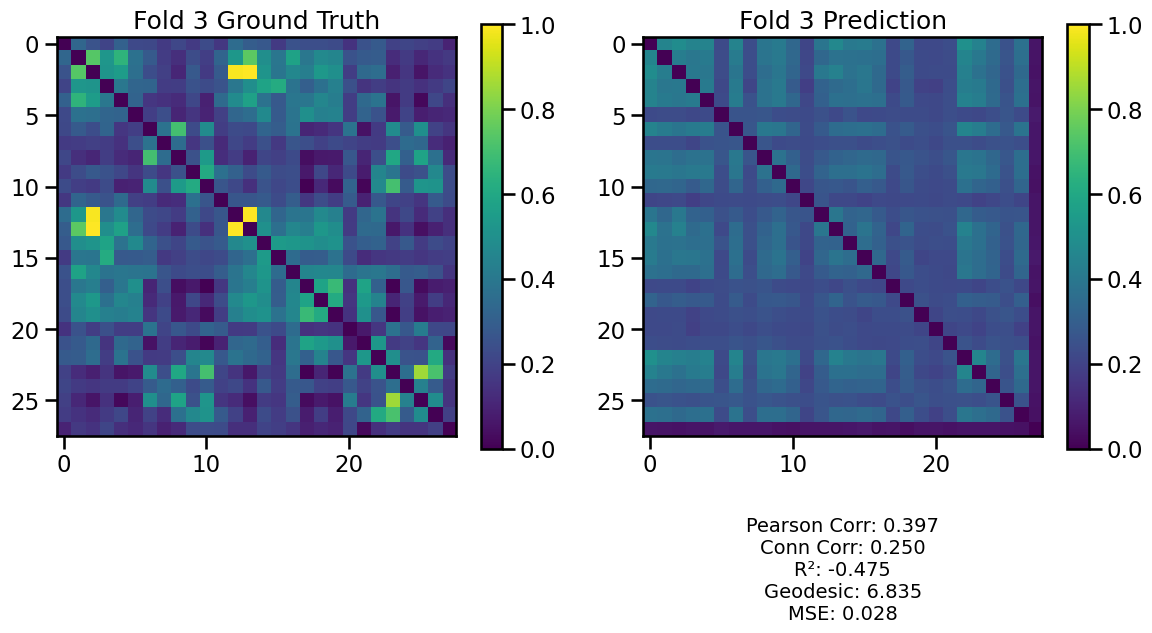

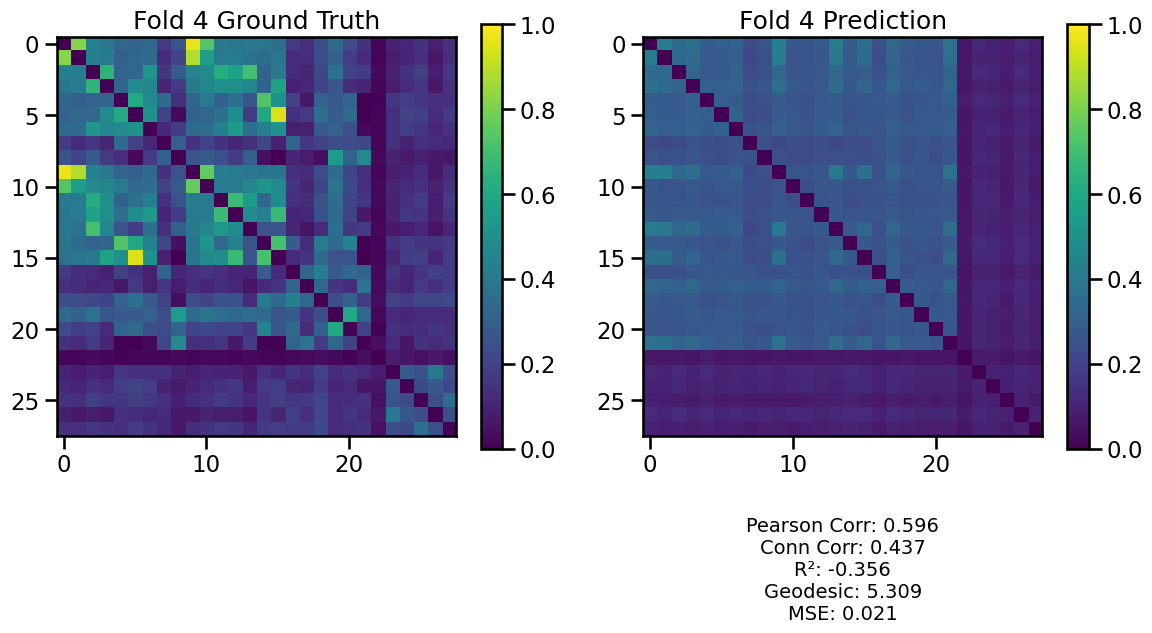

euclidean


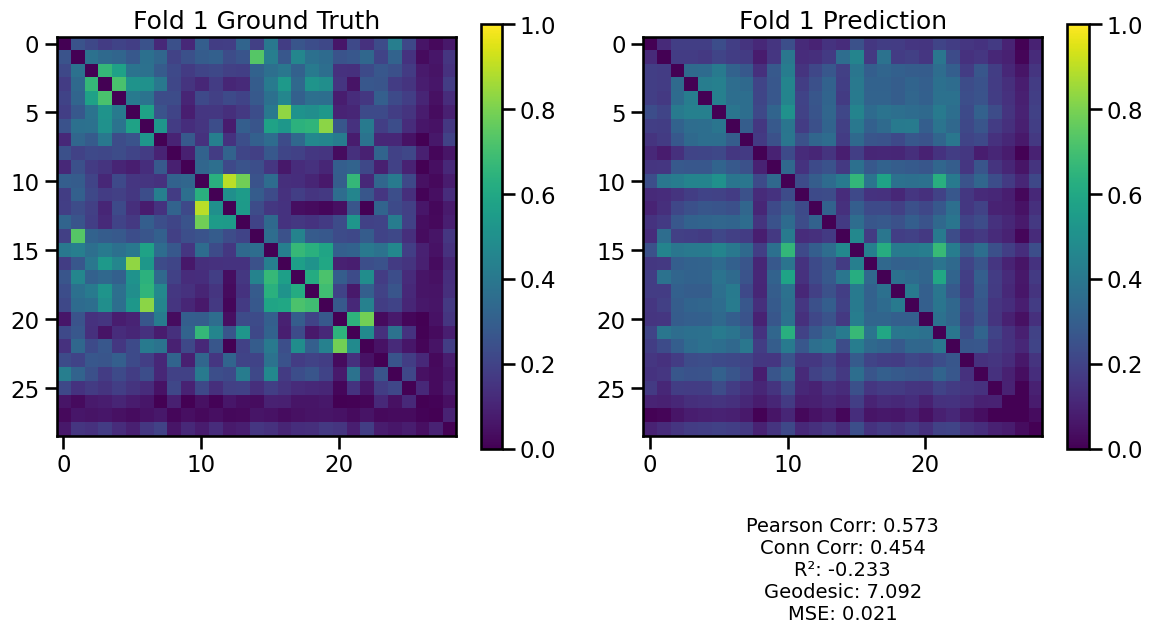

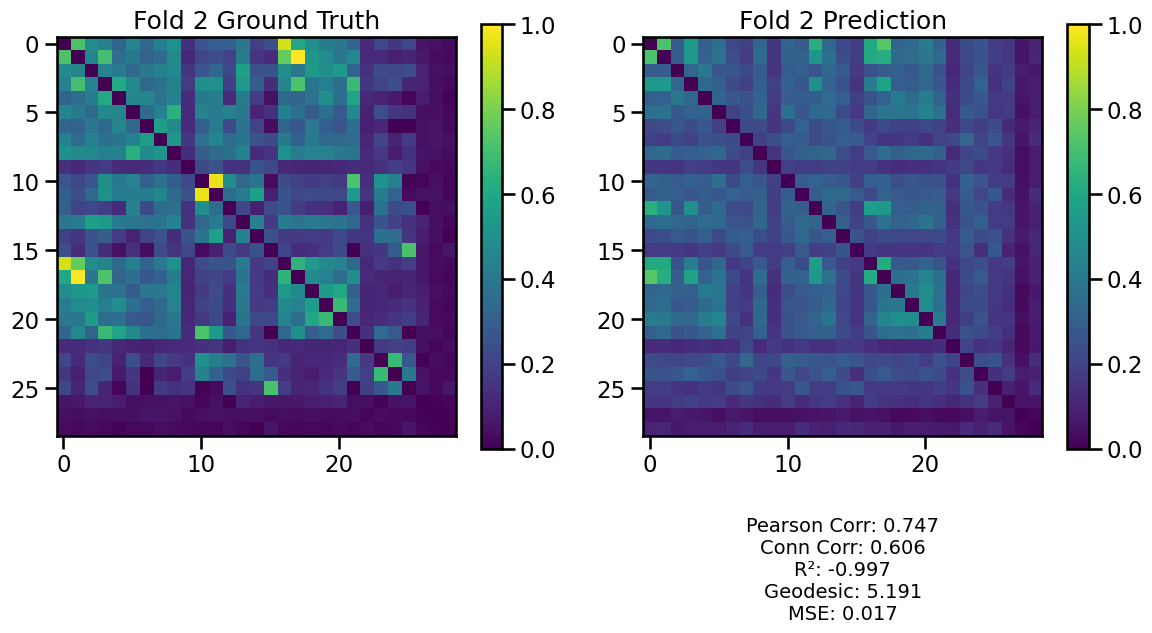

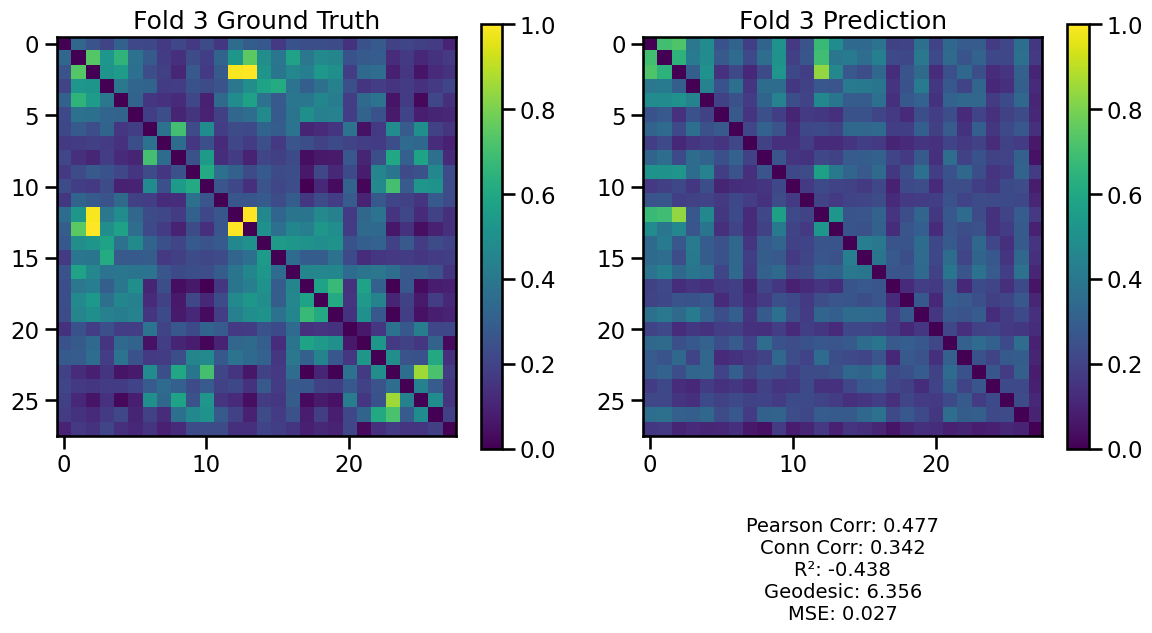

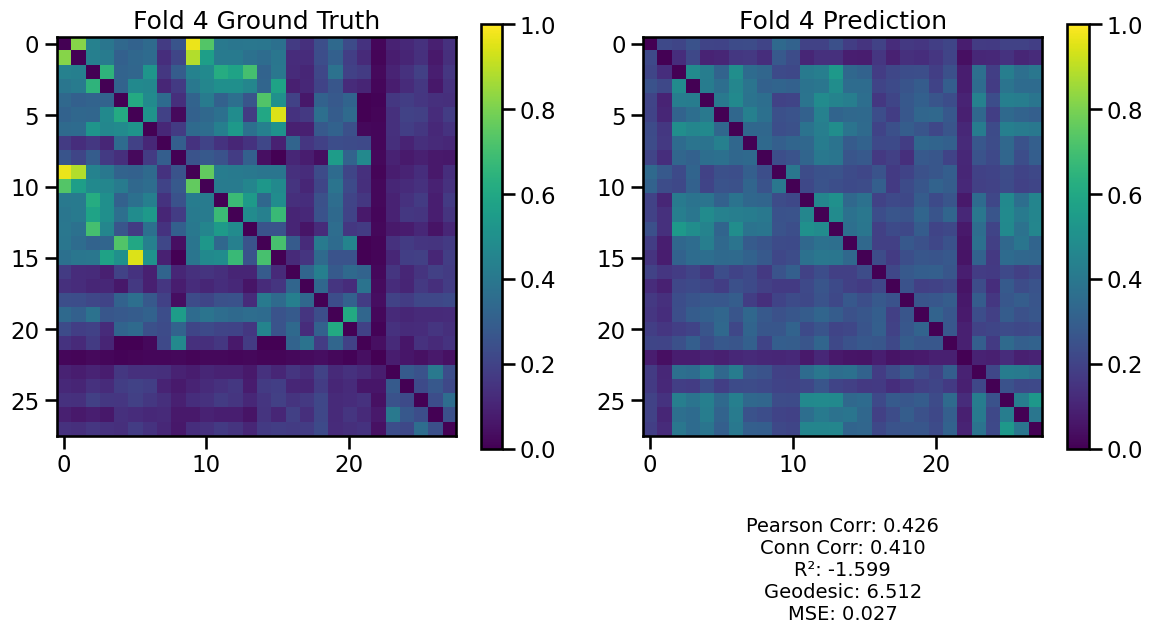

structural


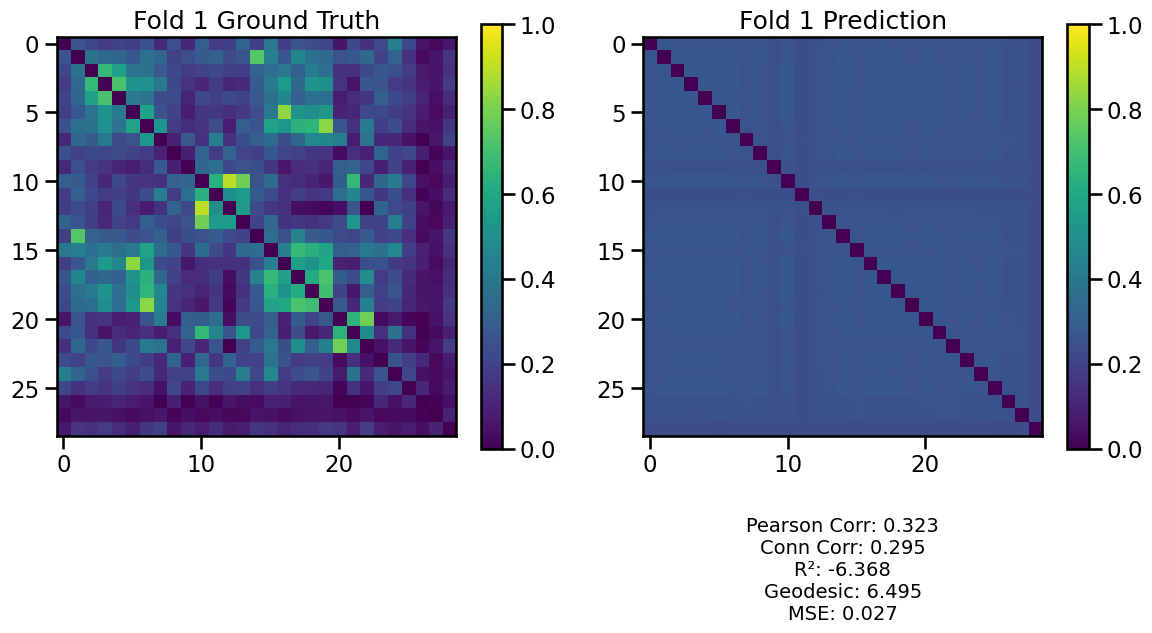

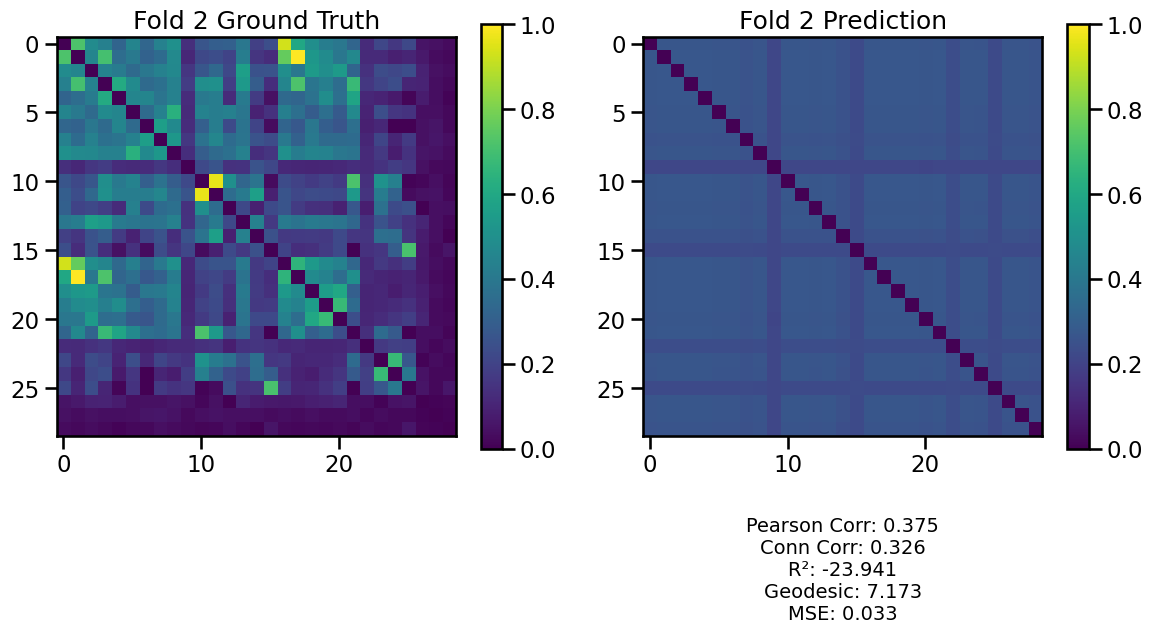

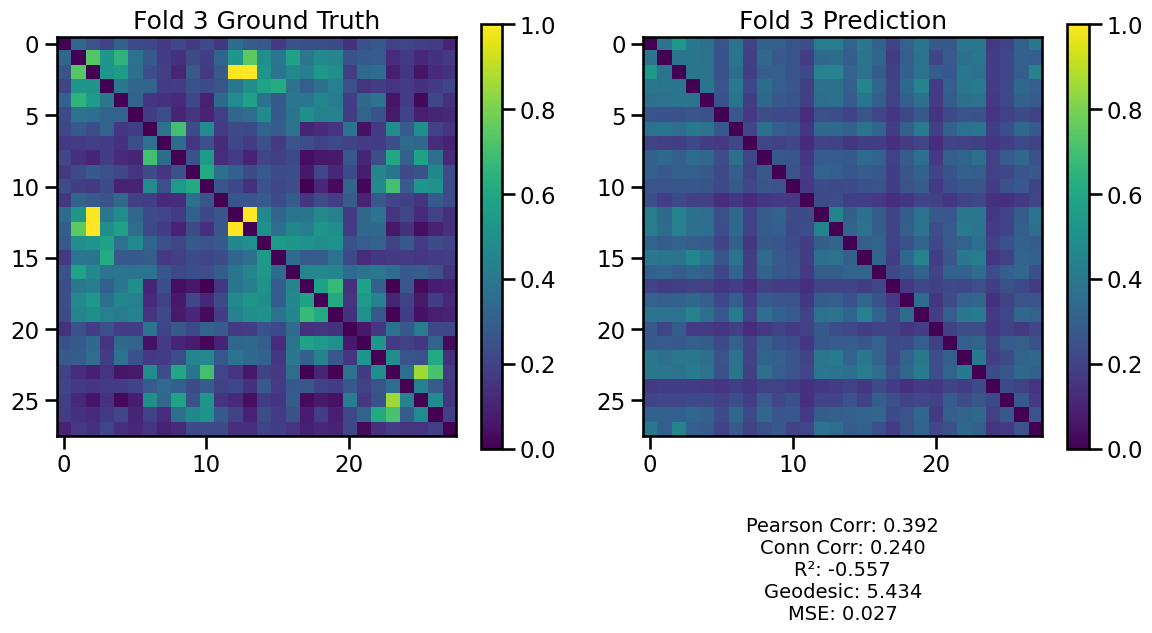

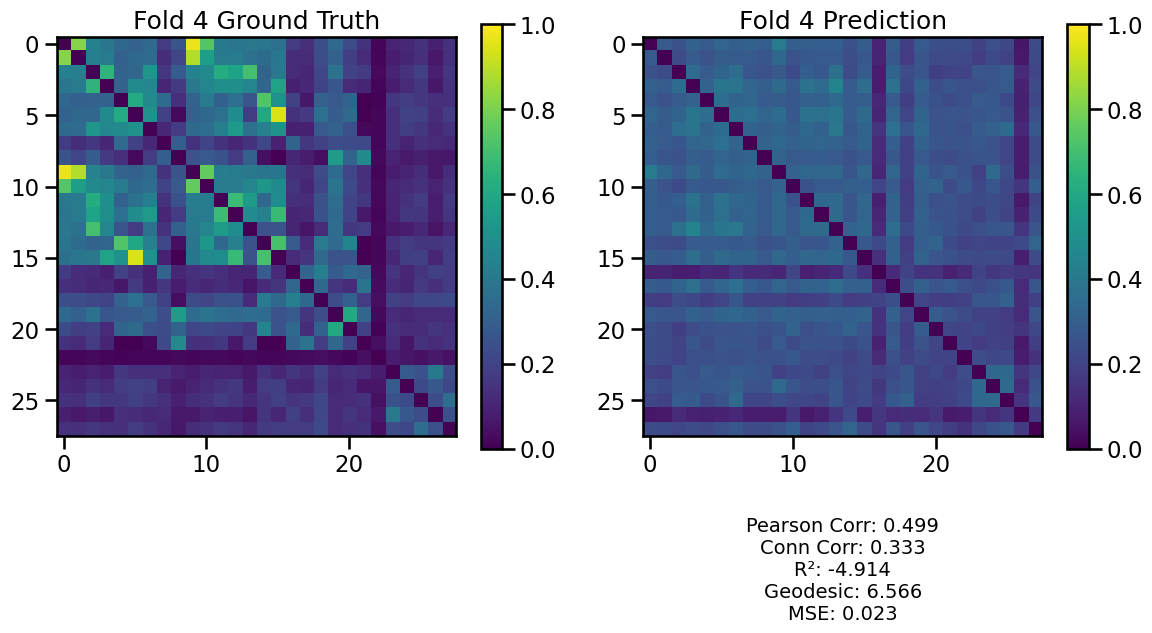

In [22]:
print('transcriptome')
results = open_pickled_results('transcriptome_xgboost_random_bayessearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('transcriptomePCA')
results = open_pickled_results('transcriptomePCA_xgboost_random_bayessearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('euclidean')
results = open_pickled_results('euclidean_xgboost_random_bayessearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('structural')
results = open_pickled_results('structural_xgboost_random_bayessearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

transcriptome


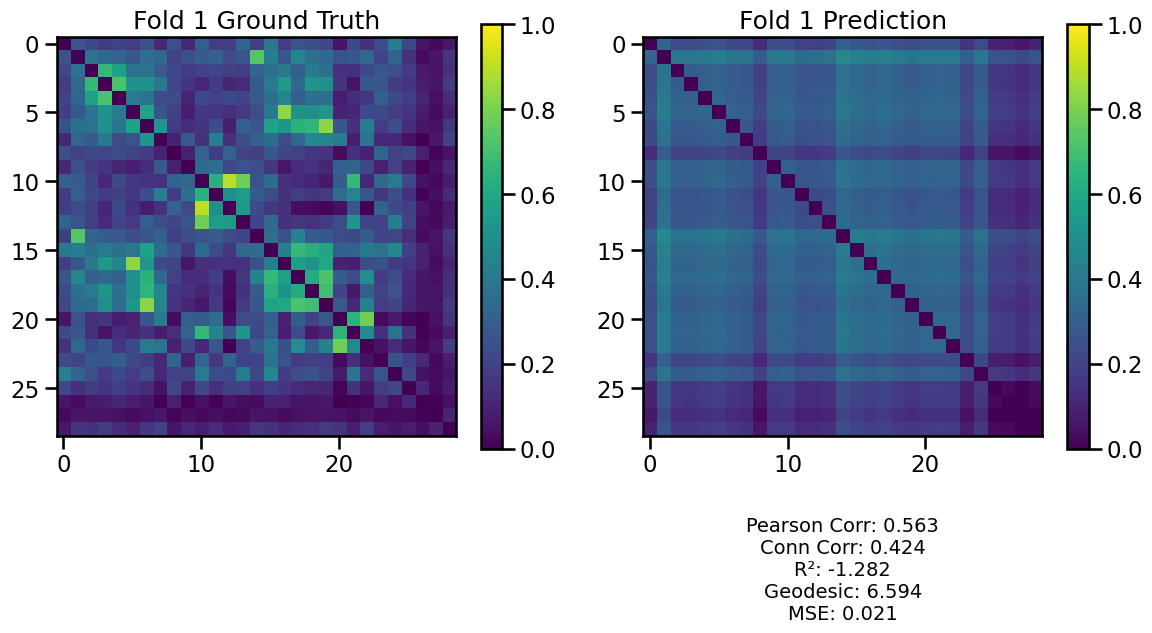

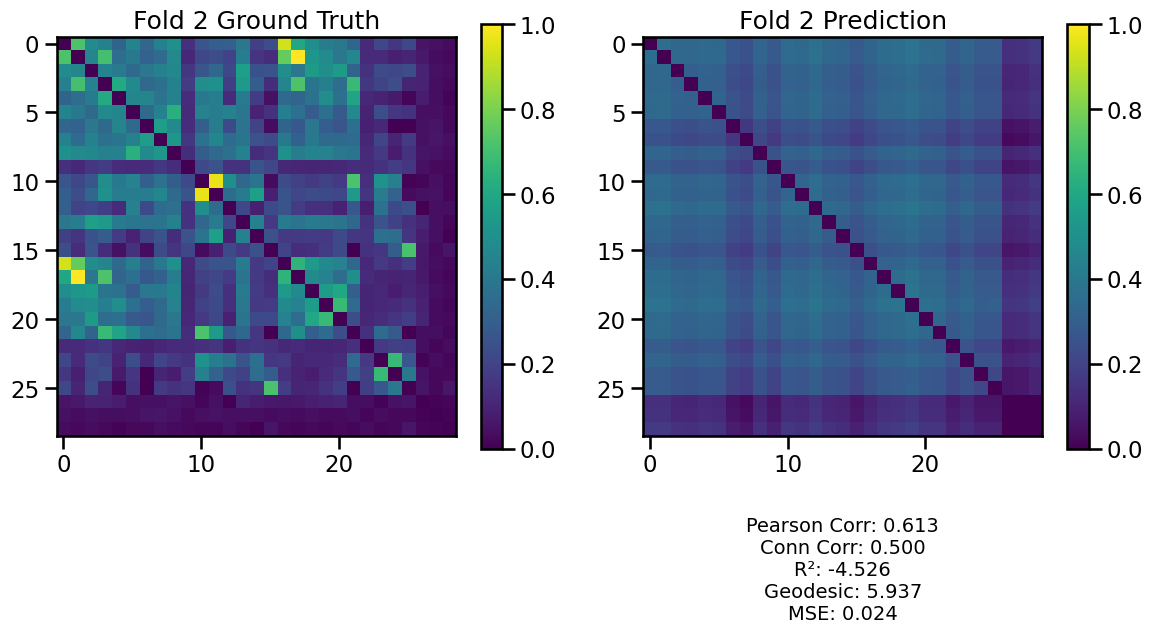

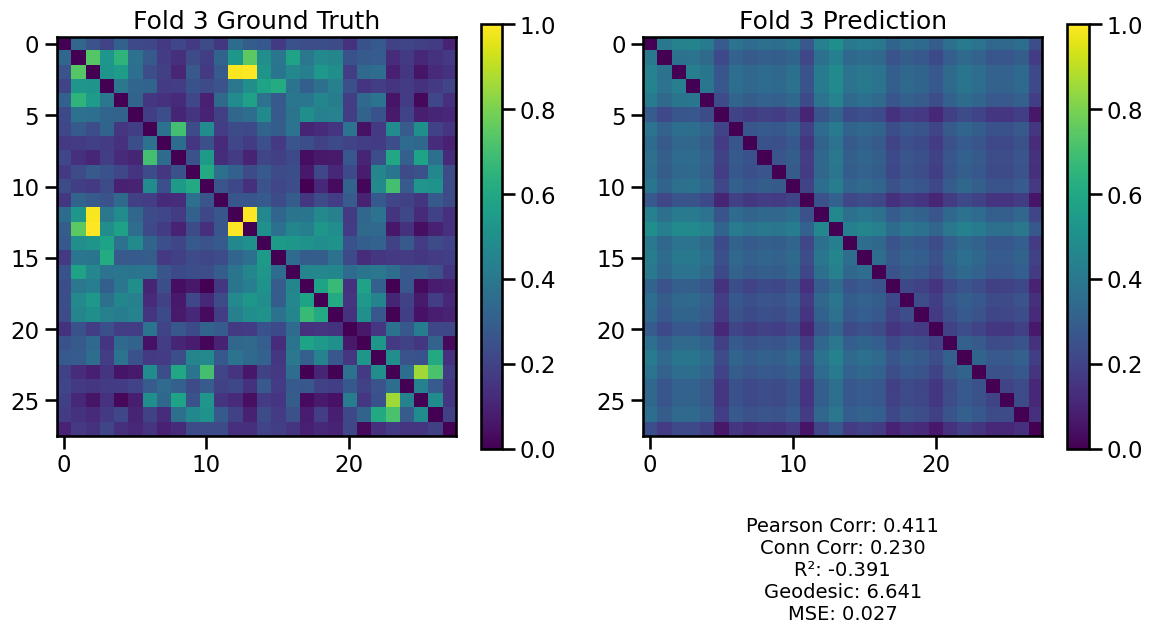

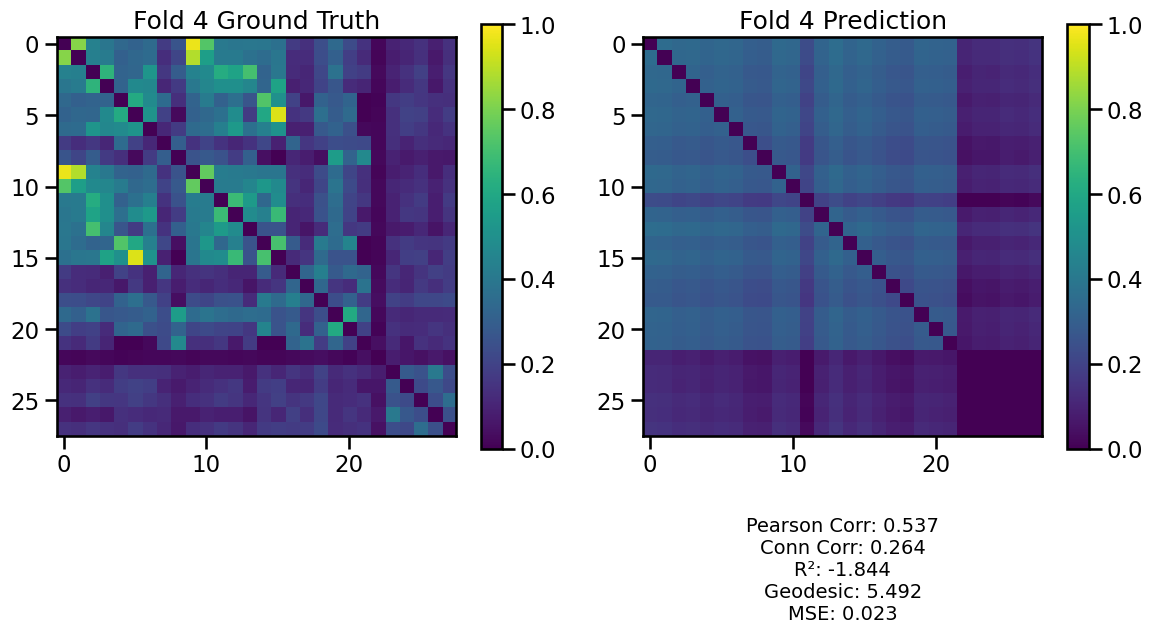

transcriptomePCA


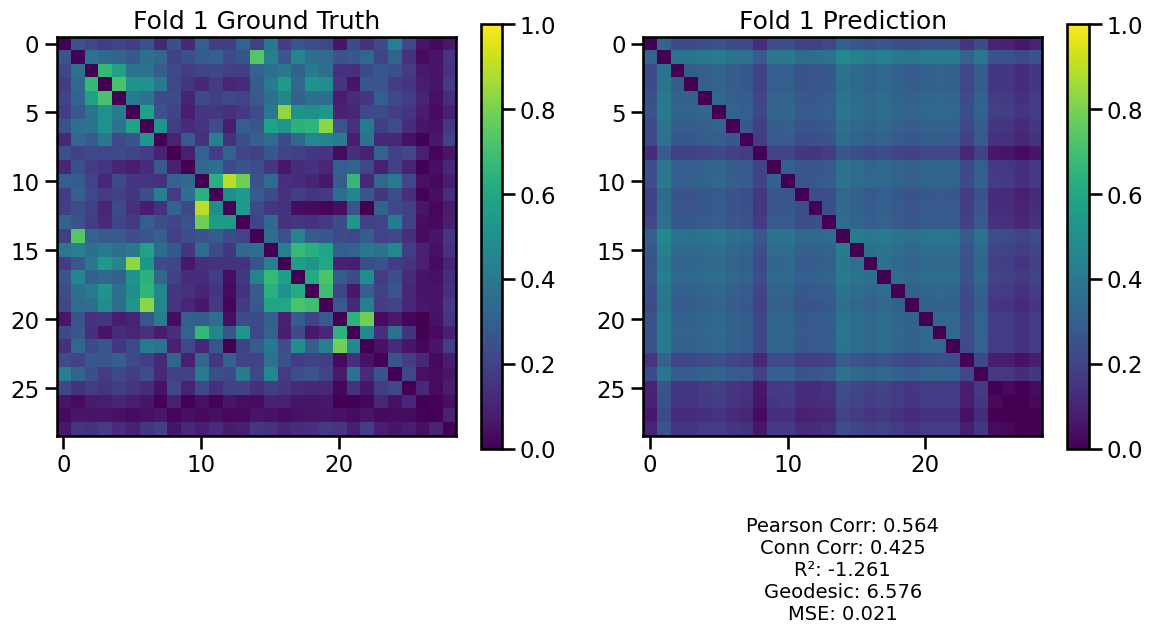

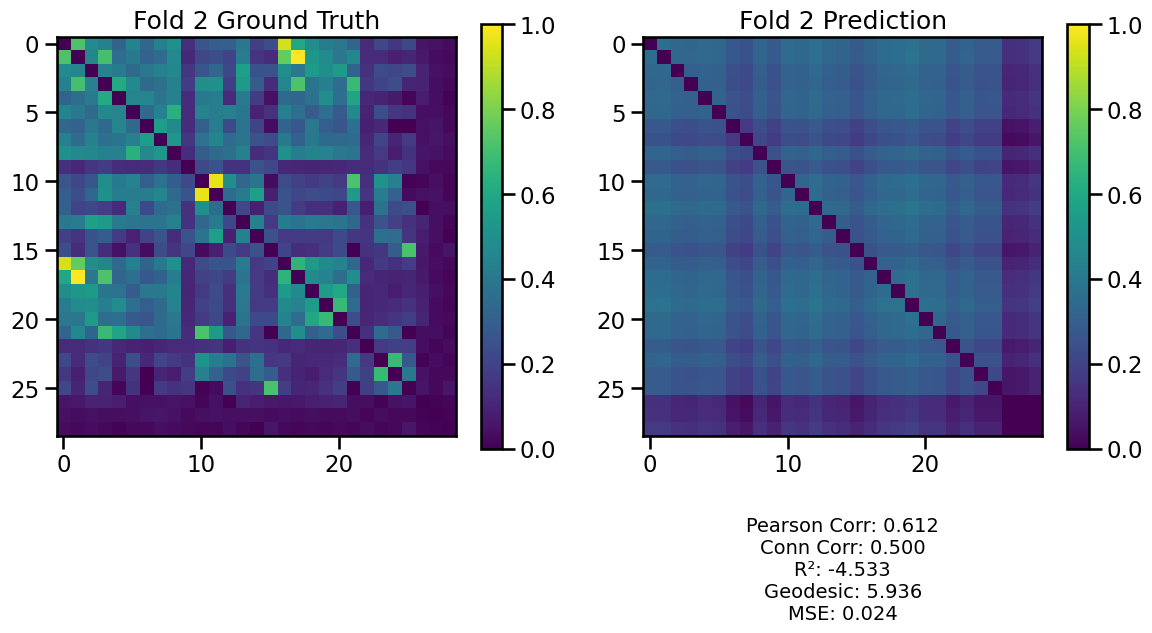

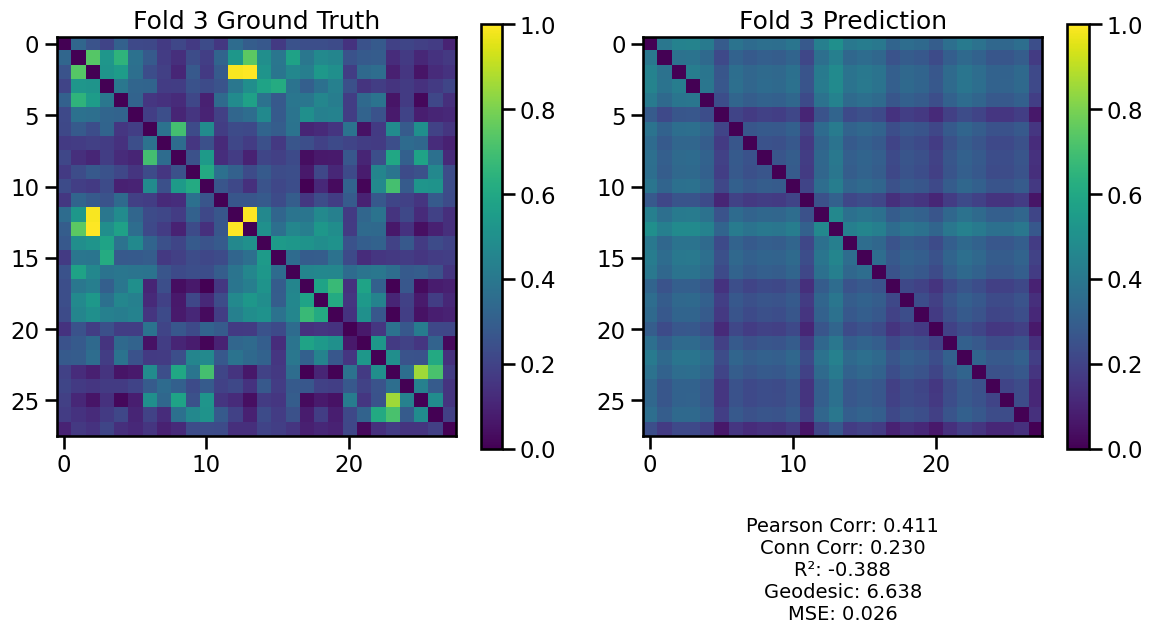

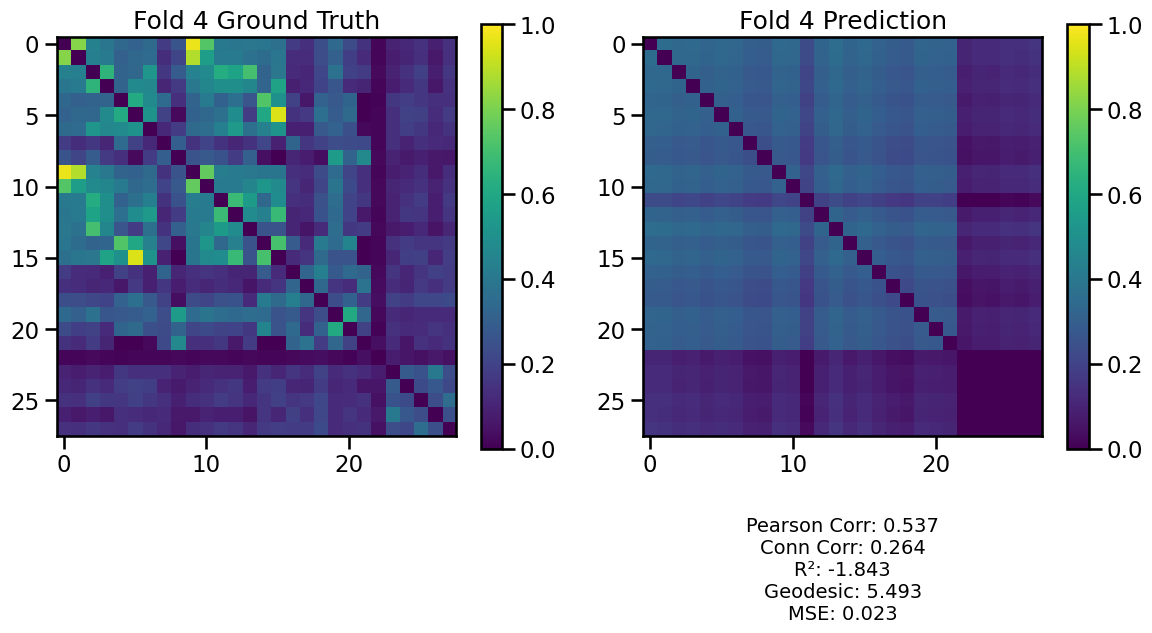

euclidean


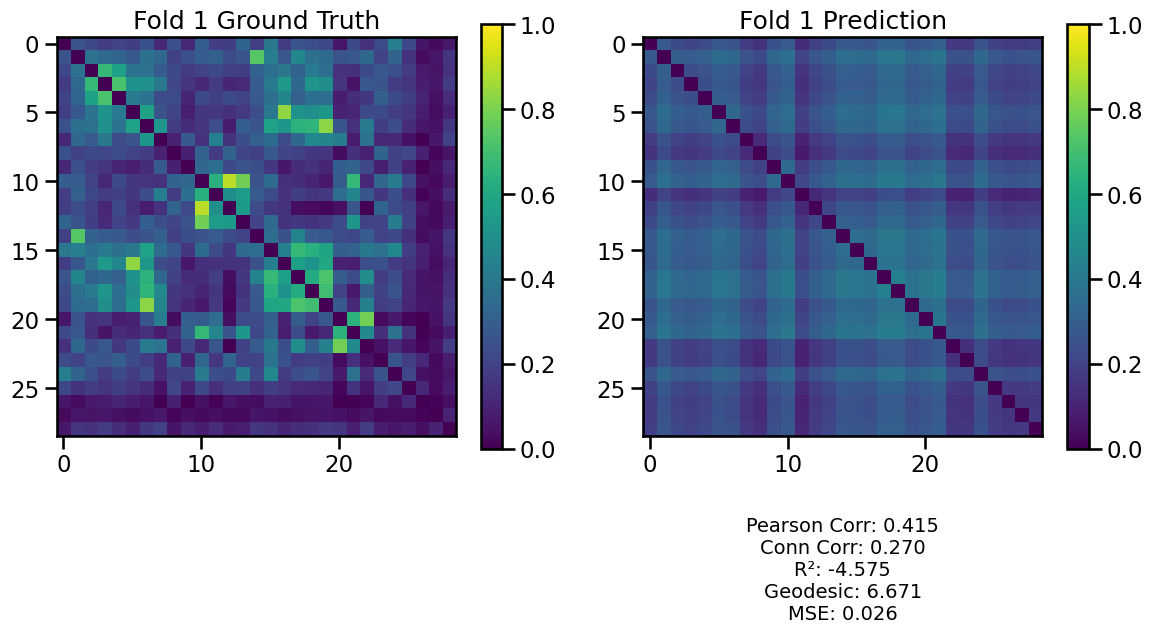

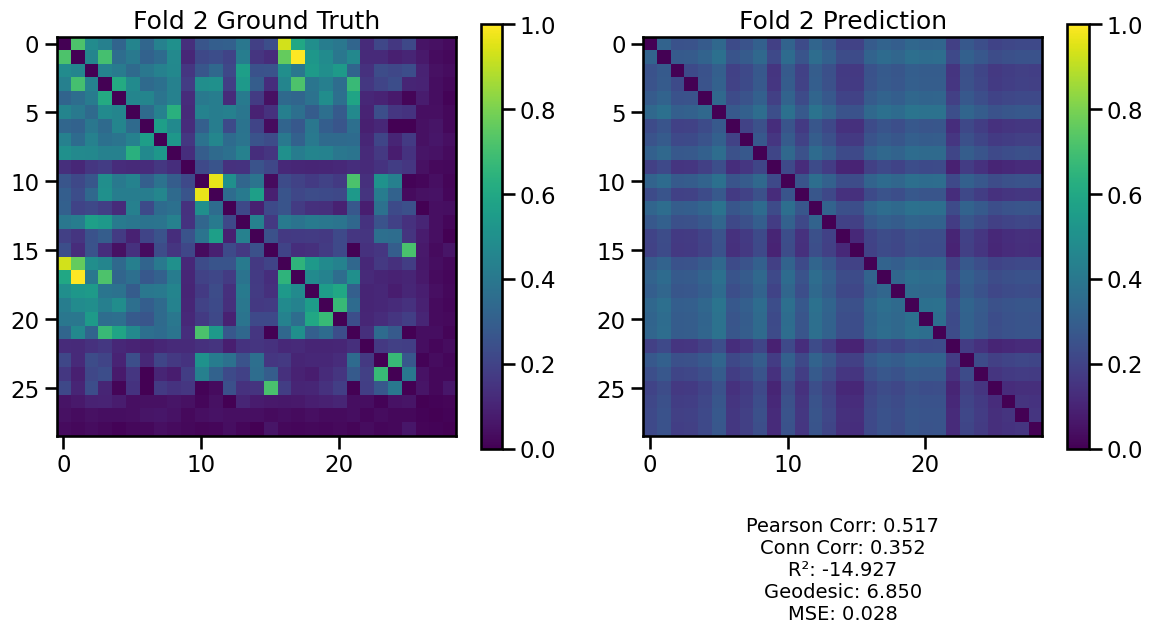

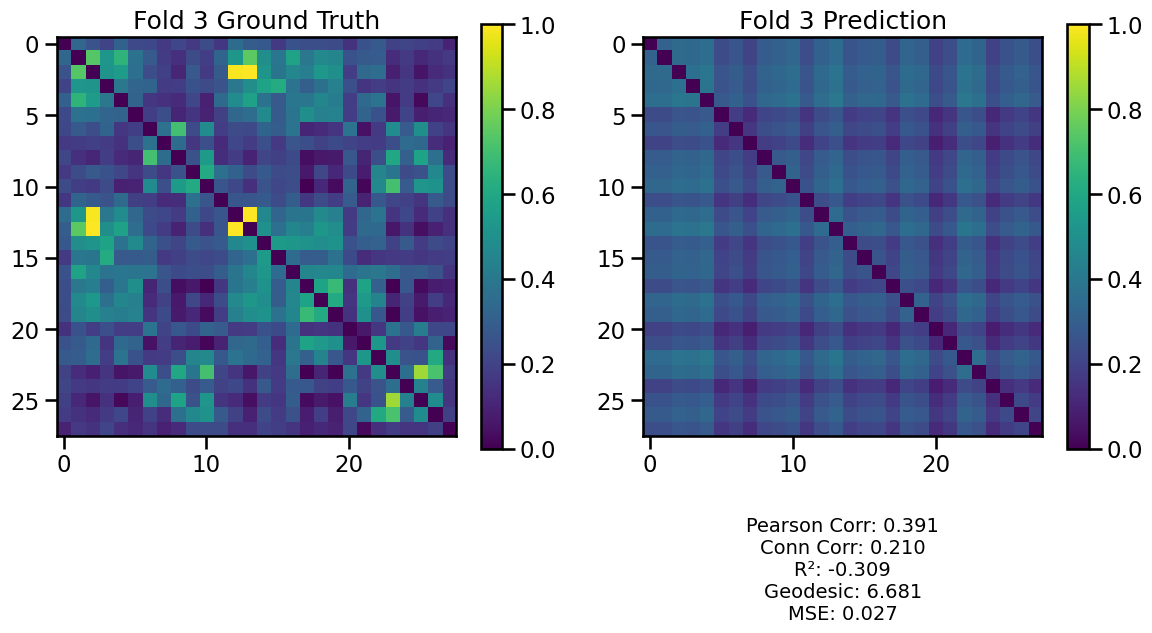

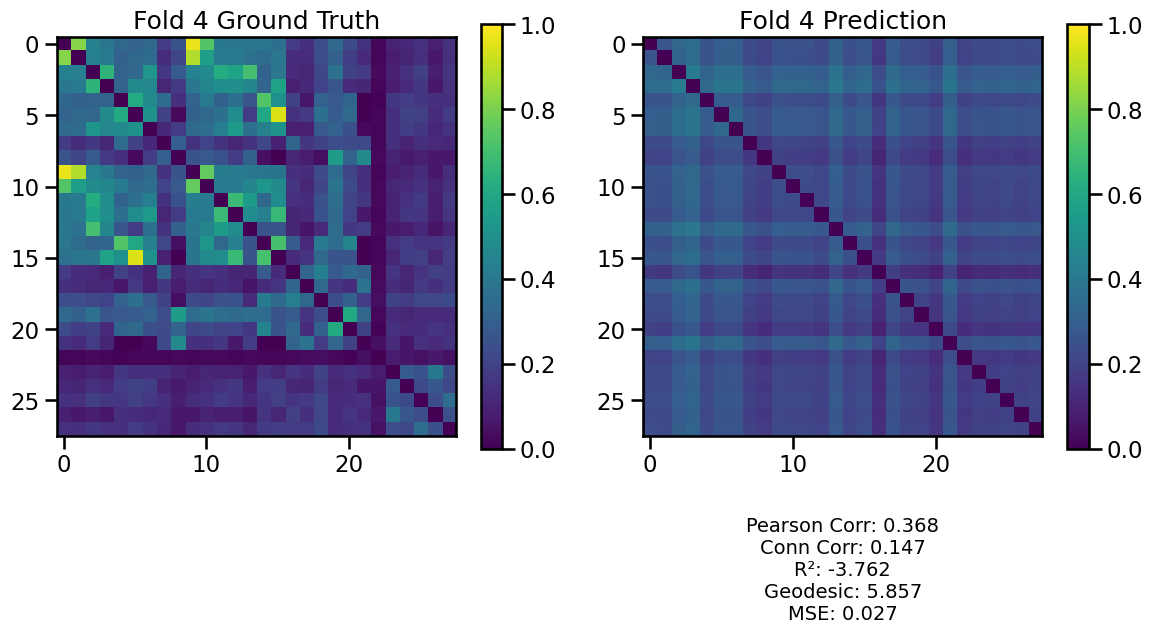

structural


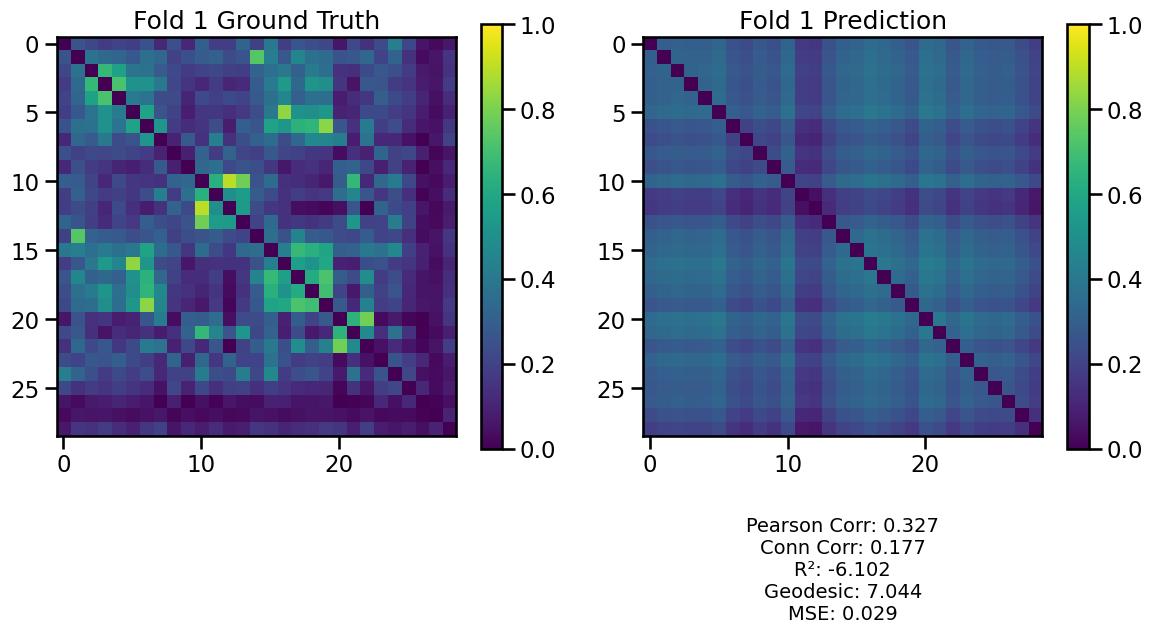

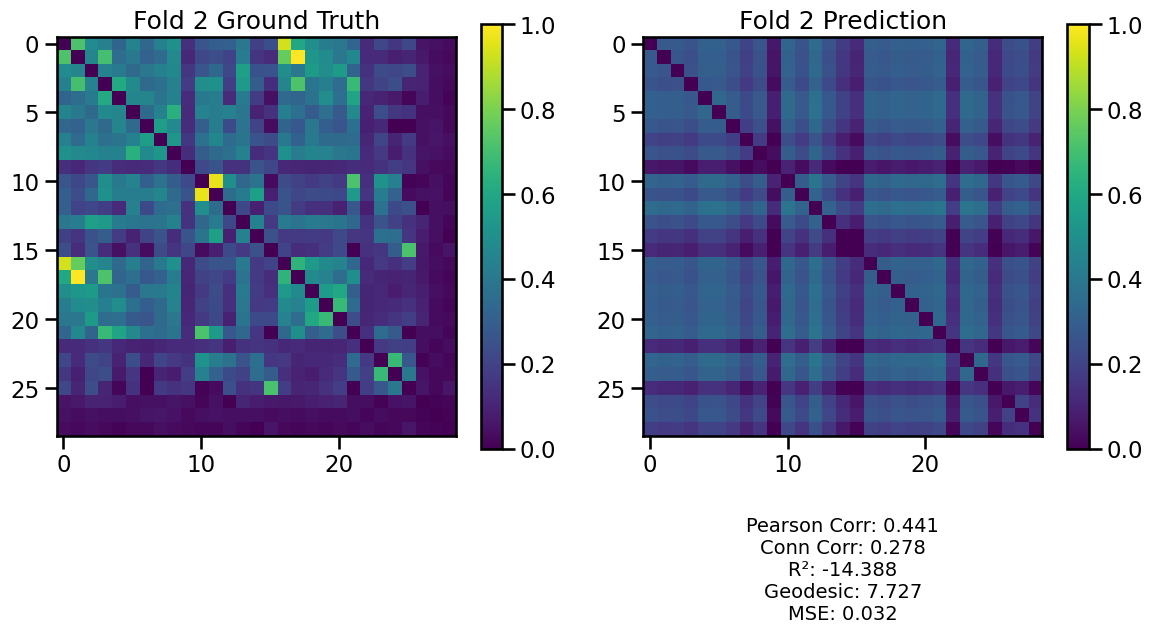

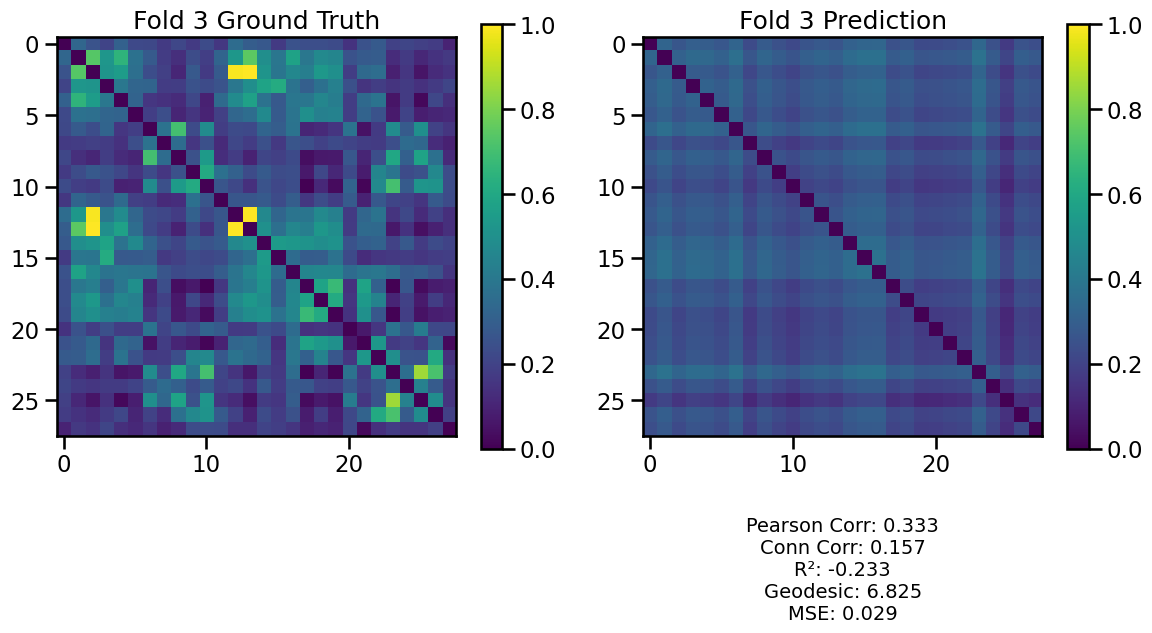

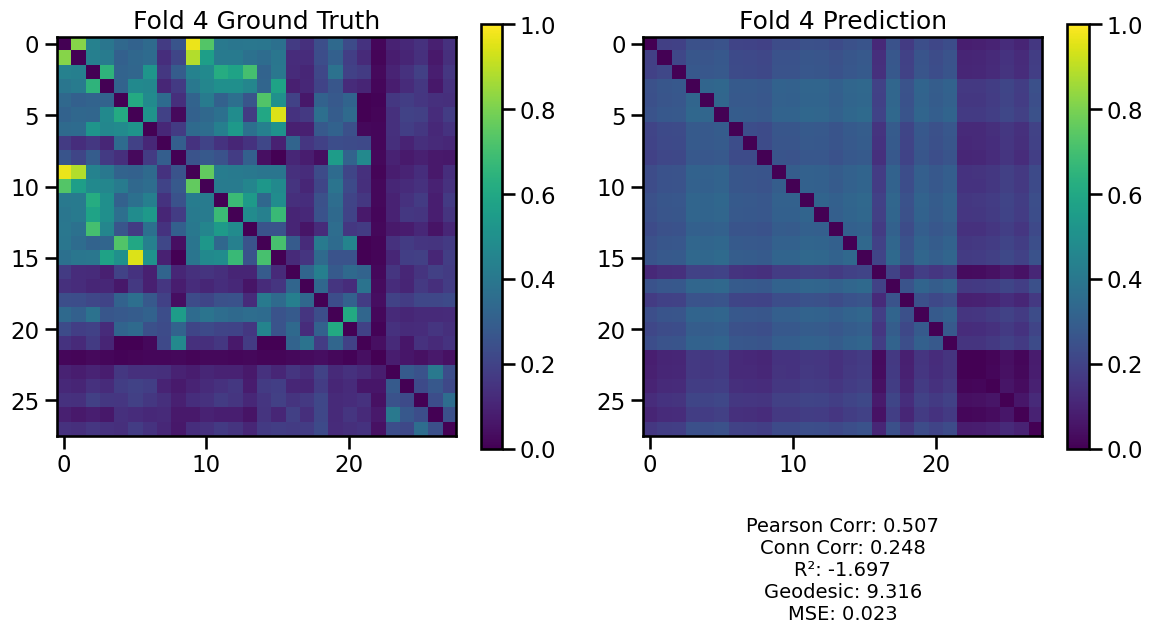

In [23]:
print('transcriptome')
results = open_pickled_results('transcriptome_pls_random_gridsearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('transcriptomePCA')
results = open_pickled_results('transcriptomePCA_pls_random_gridsearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('euclidean')
results = open_pickled_results('euclidean_pls_random_gridsearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

print('structural')
results = open_pickled_results('structural_pls_random_gridsearch.pickle', 'SFN_runs/')
plot_single_model_predictions_with_metrics(results)

### Combined feature results

In [24]:
import itertools
def extract_combined_performance_with_spaces(feature_combinations, model_type='xgboost', cv_split='community', resolution='102_2', search_type='grid', metric='pearson_corr', sim_path=SFN_sim_path):
    """
    Extracts performance metrics for combined feature types (pairs or triples) and aggregates them over all community splits.
    
    Args:
    - feature_combinations: List of feature combinations (e.g., pairs or triples of features).
    - model_type: The type of model to use (e.g., 'xgboost' or 'pls').
    - cv_split: The type of cross-validation split (e.g., 'community').
    - metric: The performance metric to extract (e.g., 'pearson_corr').
    - sim_path: Path to the saved pickle files.
    
    Returns:
    - DataFrame containing the average performance and error for each feature combination.
    """
    data = []

    # Iterate over each feature combination
    for feature_comb in feature_combinations:
        # Join feature names with spaces, not underscores
        feature_name = ' '.join(feature_comb)
        print(f'Processing feature combination: {feature_name}')
        
        # Construct pickle file name pattern based on feature combination, model type, and CV split
        pickle_file_pattern = f"{feature_name}_{model_type}_{cv_split}_{search_type}search{resolution}.pickle"
        print(pickle_file_pattern)
        
        # Check if the file exists
        if pickle_file_pattern in os.listdir(sim_path):
            # Extract the performance metrics for the train and test sets
            results = open_pickled_results(pickle_file_pattern, 'SFN_runs/')
            
            if results:
                # Iterate over each fold in the results (assuming fold results are directly stored)
                fold_performances = []
                for fold_results in results[0]:
                    # Extract test metrics
                    test_score = fold_results['test_metrics'][metric]
                    fold_performances.append(test_score)
                    
                # Compute average and error (standard deviation) over folds
                avg_performance = np.mean(fold_performances)
                error = np.std(fold_performances)
                
                # Store the aggregated results
                data.append({
                    'Feature Combination': feature_name,
                    'Average Performance': avg_performance,
                    'Error': error
                })
                
        else:
            print(f"Pickle file not found for feature combination: {feature_name}")

    # Convert to DataFrame for easy analysis
    combined_performance_df = pd.DataFrame(data)
    return combined_performance_df

feature_types = ['transcriptomePCA', 'structural', 'euclidean', 'transcriptome']

# Example usage:
# List all possible feature pairs and triples
feature_pairs = list(itertools.combinations(feature_types, 2))
feature_triples = list(itertools.combinations(feature_types, 3))

# Extract performance for xgboost and pls models (can do it for both)
#xgboost_pairs_performance_df = extract_combined_performance_with_spaces(feature_pairs, model_type='xgboost', cv_split='community', search_type='bayes')
pls_pairs_performance_df = extract_combined_performance_with_spaces(feature_pairs, model_type='pls', cv_split='community', search_type='grid')

#xgboost_triples_performance_df = extract_combined_performance_with_spaces(feature_triples, model_type='xgboost', cv_split='community', search_type='bayes')
pls_triples_performance_df = extract_combined_performance_with_spaces(feature_triples, model_type='pls', cv_split='community', search_type='grid')

Processing feature combination: transcriptomePCA structural
transcriptomePCA structural_pls_community_gridsearch102_2.pickle
Processing feature combination: transcriptomePCA euclidean
transcriptomePCA euclidean_pls_community_gridsearch102_2.pickle
Processing feature combination: transcriptomePCA transcriptome
transcriptomePCA transcriptome_pls_community_gridsearch102_2.pickle
Processing feature combination: structural euclidean
structural euclidean_pls_community_gridsearch102_2.pickle
Processing feature combination: structural transcriptome
structural transcriptome_pls_community_gridsearch102_2.pickle
Processing feature combination: euclidean transcriptome
euclidean transcriptome_pls_community_gridsearch102_2.pickle
Processing feature combination: transcriptomePCA structural euclidean
transcriptomePCA structural euclidean_pls_community_gridsearch102_2.pickle
Processing feature combination: transcriptomePCA structural transcriptome
transcriptomePCA structural transcriptome_pls_community

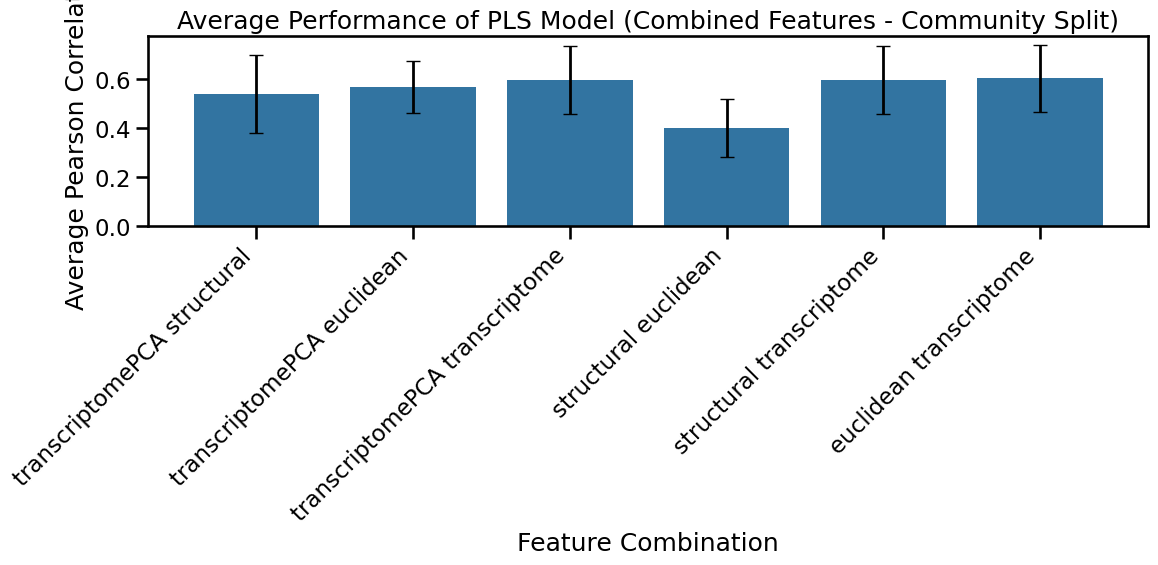

In [25]:
def plot_combined_performance_with_spaces(performance_df, model_type='xgboost'):
    """
    Plot average performance with error bars for combined feature types (pairs or triples).
    
    Args:
    - performance_df: DataFrame containing average performance and error.
    - model_type: The type of model to use (e.g., 'xgboost' or 'pls').
    """
    plt.figure(figsize=(12, 6))
    
    # Convert 'Error' column to a numpy array
    yerr = np.array(performance_df['Error'])

    # Plot the average performance with error bars
    sns.barplot(x='Feature Combination', y='Average Performance', data=performance_df, capsize=0.2)
    
    # Add error bars manually using matplotlib
    plt.errorbar(
        x=np.arange(len(performance_df)),  # x positions
        y=performance_df['Average Performance'],  # y values
        yerr=yerr,  # error values
        fmt='none',  # no connecting line
        capsize=5,   # size of the error bar caps
        color='black',  # color of error bars
        elinewidth=2,  # width of error lines
    )
    
    plt.title(f'Average Performance of {model_type.upper()} Model (Combined Features - Community Split)')
    plt.ylabel('Average Pearson Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_performance_with_spaces(pls_pairs_performance_df, model_type='pls')

Processing feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


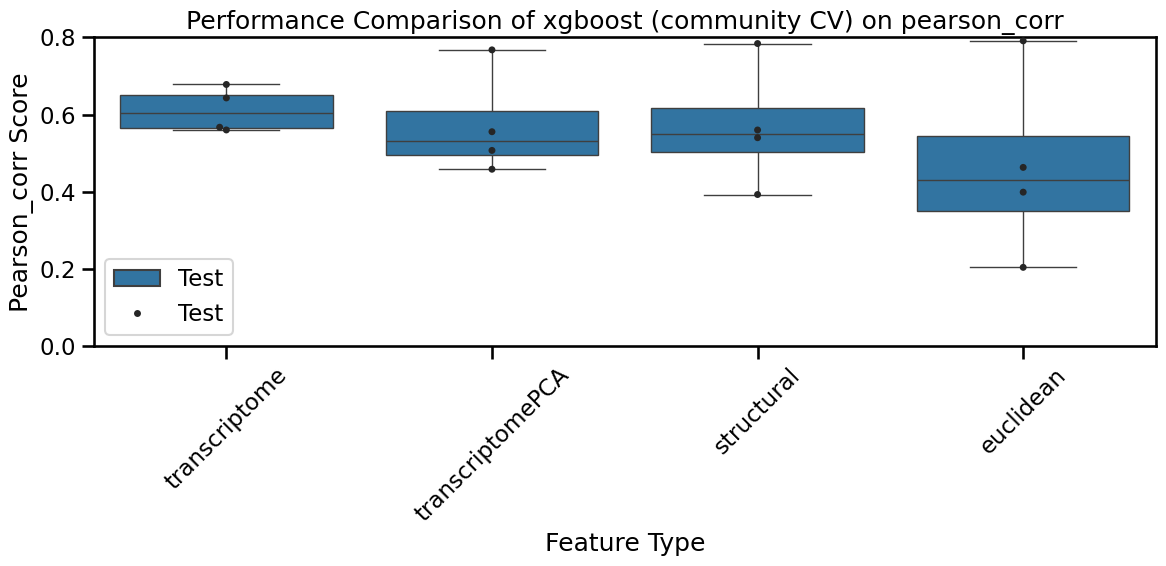

In [26]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='xgboost', cv_split='community', resolution='101_2', metric='pearson_corr', display_train_test=False)

Processing feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


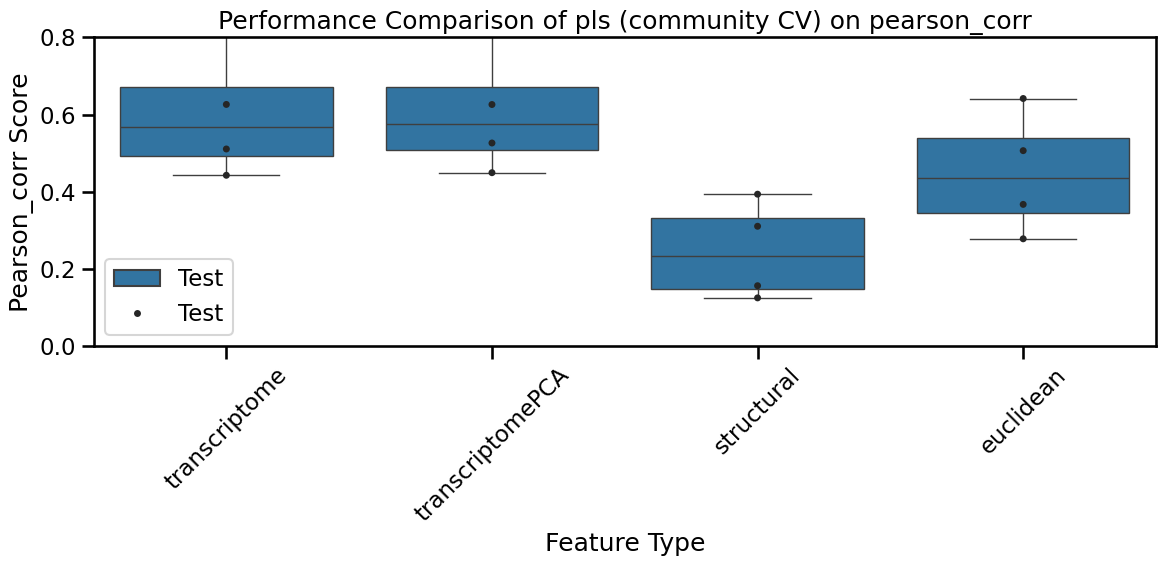

In [27]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='pls', cv_split='community', resolution='101_2', metric='pearson_corr', search_type='grid', display_train_test=False)

In [28]:
pairs = list(itertools.combinations(feature_types, 2))
pairs

pair_feature_types = ['transcriptome transcriptomePCA',
                     'transcriptome structural',
                     'transcriptome euclidean',
                     'transcriptomePCA structural',
                     'transcriptomePCA euclidean',
                     'structural euclidean']

Processing feature: transcriptome transcriptomePCA
Processing feature: transcriptome structural
Processing feature: transcriptome euclidean
Processing feature: transcriptomePCA structural
Processing feature: transcriptomePCA euclidean
Processing feature: structural euclidean


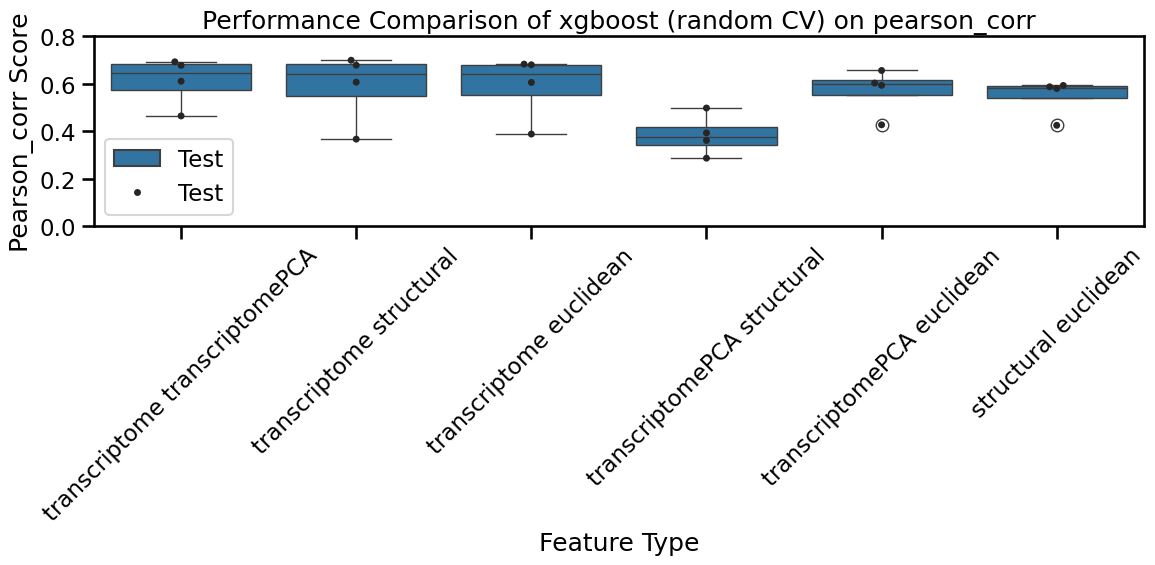

In [29]:
# Run the function to generate the plot for 'pearson_corr'
plot_performance(pair_feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', display_train_test=False)

Processing feature: transcriptome transcriptomePCA
Pickle file not found for feature: transcriptome transcriptomePCA
Processing feature: transcriptome structural
Pickle file not found for feature: transcriptome structural
Processing feature: transcriptome euclidean
Pickle file not found for feature: transcriptome euclidean
Processing feature: transcriptomePCA structural
Processing feature: transcriptomePCA euclidean
Processing feature: structural euclidean


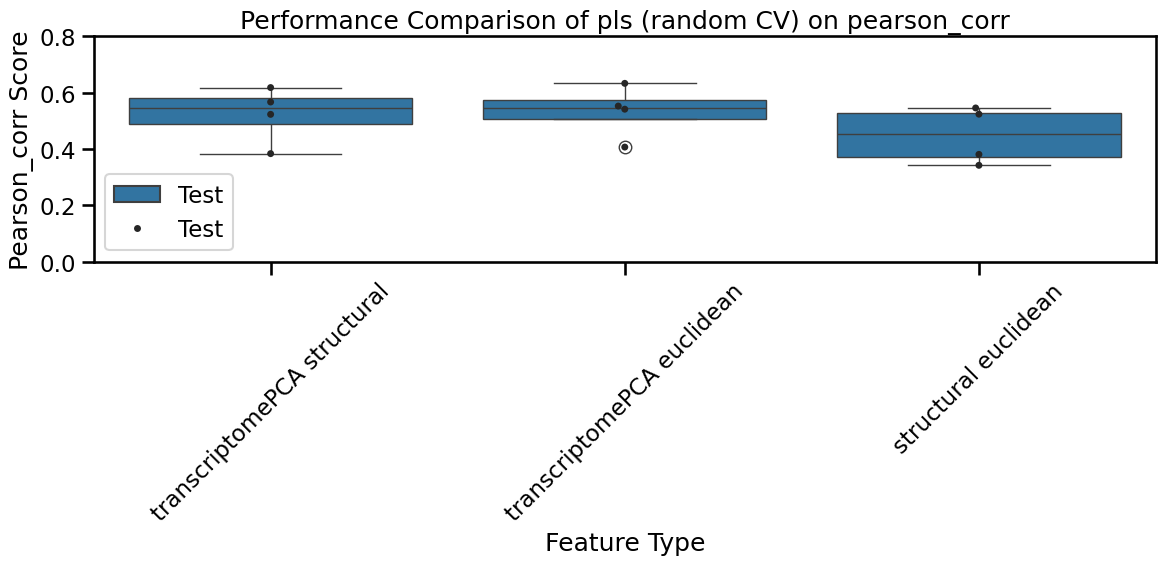

In [30]:
# Run the function to generate the plot for 'pearson_corr'
plot_performance(pair_feature_types, model_type='pls', cv_split='random', metric='pearson_corr', search_type='grid', display_train_test=False)

In [31]:
triples = list(itertools.combinations(feature_types, 3))
triples

triple_feature_types = ['transcriptome transcriptomePCA structural',
 'transcriptome transcriptomePCA euclidean',
 'transcriptome structural euclidean',
 'transcriptomePCA structural euclidean']


Processing feature: transcriptome transcriptomePCA structural
Processing feature: transcriptome transcriptomePCA euclidean
Processing feature: transcriptome structural euclidean
Processing feature: transcriptomePCA structural euclidean


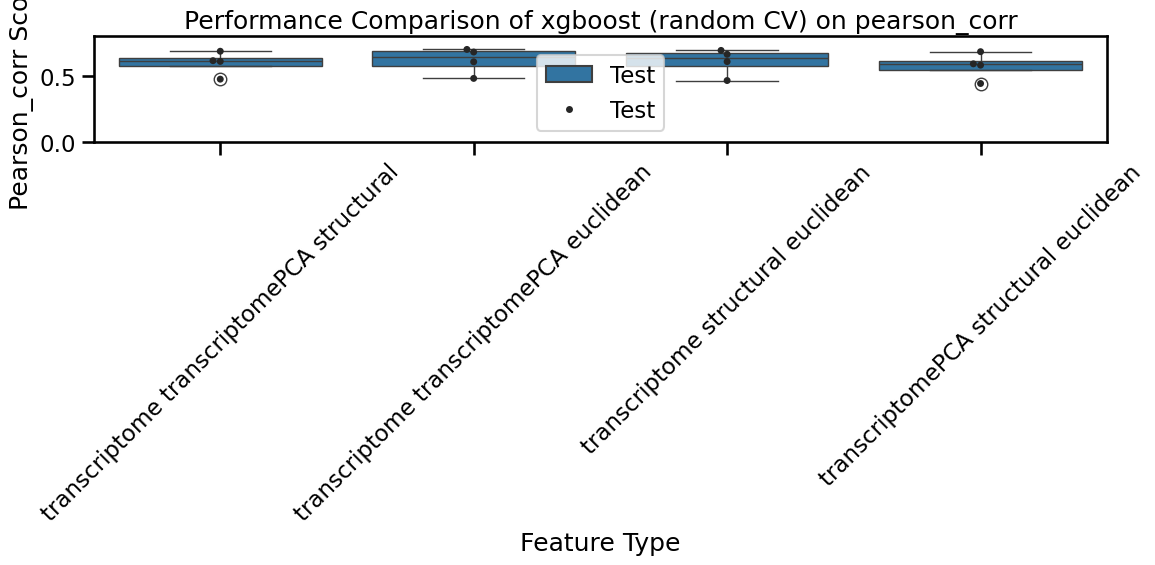

In [32]:
plot_performance(triple_feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', display_train_test=False)